In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy import interpolate
color = sns.color_palette()
%matplotlib inline
import sys
import importlib
importlib.reload(sys)
mpl.rcParams['font.sans-serif'] = ['SimHei']

In [12]:
# 因为数据包含了中文，所以要改变编码方式
data = pd.read_csv('all_house_info.csv',encoding ='gb18030')

In [13]:
# 查看特征的数值类型以及维度
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 28 columns):
Address              2666 non-null object
District             2666 non-null object
Community            2666 non-null object
Area                 2666 non-null int64
RentPrice            2666 non-null object
Layer                2666 non-null object
Shape                2666 non-null object
Toward               2666 non-null object
Release_Date         2666 non-null object
Rent_Period          2666 non-null object
Is_lift              2666 non-null object
Is_parking           2666 non-null object
water_way            2666 non-null object
electricity_way      2666 non-null object
Subwayline_Number    2666 non-null int64
Subway_Distance      2666 non-null int64
Is_TV                2666 non-null int64
Is_fridge            2666 non-null int64
Is_washer            2666 non-null int64
Is_air               2666 non-null int64
Is_heater            2666 non-null int64
Is_bed             

###### 观察数据的总体特征，对数据有基本的了解
通过观察均值mean、最大值max、最小值min、上下四分数以及与均值之间的关系
* 房屋面积的最大值是1236平方米，最小值是12平方米
* 地铁站最大值是18，考虑到房屋周围地铁站的数目应该不会有这么多，暂时认为18个的是**虚假信息**，并且个人认为周围的地铁站数目应该小于7，通过均值和中位数，认为房屋周围的地铁站数量应该是2站左右
* 对于距离地铁线路的距离，不排除有些居民楼、商业楼建在地铁站上方
* 对于房屋配套的设施，通过观察均值以及上四分数和中位数，发现配备设施并不准确，理论上房屋的基本配套设施如床应该是有的，但是均值只有0.3，即7层的房屋没有床，我们认为这是不合理的，所以，链家网上的配套设施信息**不准确**。

In [14]:
data.describe()

,Area,Subwayline_Number,Subway_Distance,Is_TV,Is_fridge,Is_washer,Is_air,Is_heater,Is_bed,Is_heating,Is_wifi,Is_closet,Is_gas
count,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000
mean,70.973368,1.700300,390.617029,0.255064,0.303451,0.300825,0.311328,0.304951,0.311703,0.133908,0.166542,0.309077,0.270818
std,43.374157,1.544771,347.469262,0.435979,0.459834,0.458703,0.463123,0.460473,0.463276,0.340618,0.372636,0.462200,0.444465
min,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,45.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,62.000000,1.000000,353.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,89.000000,3.000000,668.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,1236.000000,18.000000,1189.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 对非数值特征进行观察和处理
* 各非数值特征的取值含义，是否含有缺失值
* 进行相应的处理或者是转换

In [15]:
# 信息采集时间转换成datetime属性,并查看信息抓取的时间
import time
import datetime
data['Catch_time'] = pd.to_datetime(data['Catch_time'])
data["date"] = data['Catch_time'].apply(lambda x:datetime.datetime.strftime(x,'%Y-%m-%d'))


In [16]:
# 可以发现，数据都是在7月13日抓取的
data["date"].value_counts()

2019-07-13    2666
Name: date, dtype: int64

浦东    676
徐汇    295
闵行    282
普陀    181
杨浦    161
宝山    158
松江    151
黄浦    145
虹口    127
长宁    123
嘉定    104
闸北     99
静安     90
青浦     40
奉贤     32
金山      2
Name: Address, dtype: int64


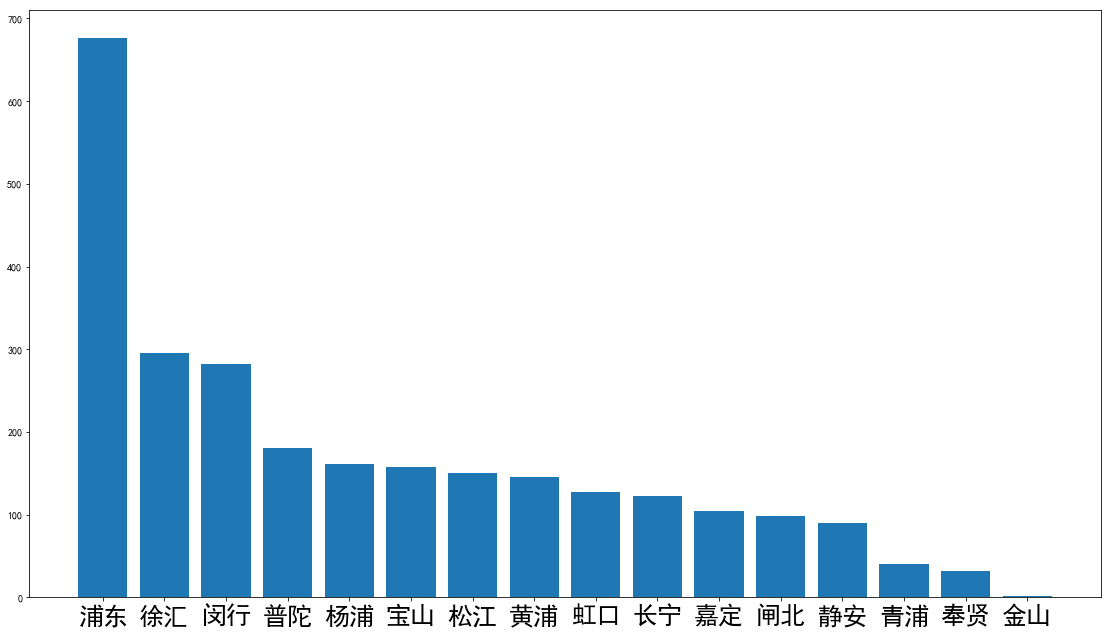

In [82]:
# 再看看房屋的地区覆盖了上海的市辖区
print(data["Address"].value_counts())
# print(type(data["Address"].value_counts()))
Address_range = data["Address"].value_counts()
Address_amount = [x for x in Address_range[0:]]
Address_name = list(Address_range.index)
plt.figure(figsize=(19.2,10.8))
plt.xticks(fontsize=25)
plt.bar(Address_name,Address_amount)
plt.savefig('image/Address_Atri.png')

可以发现，出租的房屋大多数分布在**浦东区**，其次是**徐汇区**、**闵行**
其次，**金山区**是最少的，只有2条出租信息。
考虑到浦东新区这几年的快速发展，其政治、经济、科技实力不断强大，截止2016年底，浦东新区常住人口达550.1万人，越来越来的金融、科技人士都在浦东区工作和居住，为浦东新区注入活力，同样的，增加了人口流动，所以认为浦东新区的房屋出租信息相较于其他区会比较多。
徐汇区位于上海中心城区的西南部，东北侧与黄浦区毗邻，与浦东新区隔江相望，西与闵行区分界，北与静安区、长宁区接壤。徐汇是上海较早基本完成旧区改造的中心城区之一。同样的，徐汇重点发展**信息技术**、**现代生物医药**、**纳米新材料**等**高新技术产业**，形成区工业电子信息业和生物医药业发展的产业规模。
可见，浦东新区和徐汇区作为出租房屋信息最多的市辖区，都主要发展高新科技产业，高新科技产业的人才需求较为庞大，所以对房屋的出租产生较大的影响。

### 对月租金特征值进行分析
通过采集特征值发现，月租金分为月付价和季付价，季付是一次付三个月的钱，即要提前付一个季度的房价。
绘制表格发现，月租的付款方式和租金没有太大的关系

4500元/月            115
4000元/月             88
3500元/月             78
5500元/月             76
5000元/月             71
3800元/月             64
4800元/月             59
6500元/月             56
5500元/月 (季付价)       55
3000元/月             47
6000元/月             46
4200元/月             42
5800元/月             38
4600元/月             38
4500元/月 (季付价)       37
7500元/月             36
7000元/月             35
3600元/月             35
2800元/月             33
6000元/月 (季付价)       33
5000元/月 (季付价)       33
5200元/月             32
4300元/月             31
6500元/月 (季付价)       30
5300元/月             29
3300元/月             28
2500元/月             27
8000元/月 (季付价)       25
3700元/月             25
4800元/月 (季付价)       24
                  ... 
5250元/月              1
4499元/月 (季付价)        1
3650元/月              1
10500元/月 (年付价)       1
8700元/月 (季付价)        1
10300元/月 (季付价)       1
5150元/月              1
3950元/月 (季付价)        1
9300元/月              1
35000元/月             1
2650元/月              1
1800元/月 (月付价)        1
18000元/月 (季

<BarContainer object of 31 artists>

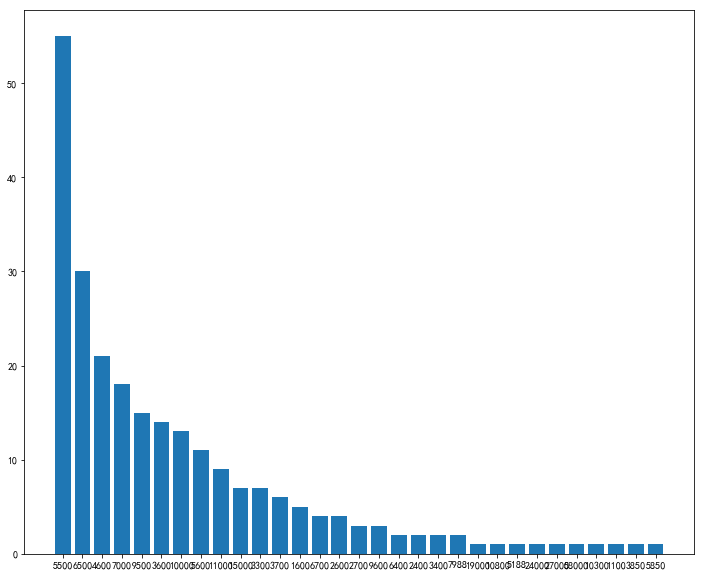

In [18]:
# 对月租金进行分析
way = data["RentPrice"].value_counts()
print(way)
way_price = data["RentPrice"].value_counts().index
way_price_amount = [x for x in data["RentPrice"].value_counts()[0:]]
jifu_name = []
jifu_price = []
yuefu_name = []
yuefu_price = []
for name,price in zip(way_price,way_price_amount):
    if name[-5:] =='(季付价)':
        jifu_name.append(name[:-9])
        jifu_price.append(price)
    else:
        yuefu_name.append(name[:-4])
        yuefu_price.append(price)
        
plt.figure(figsize=(12,10))
plt.bar(jifu_name[::4],jifu_price[::4])
# plt.plot(yuefu_name,yuefu_price)


<BarContainer object of 26 artists>

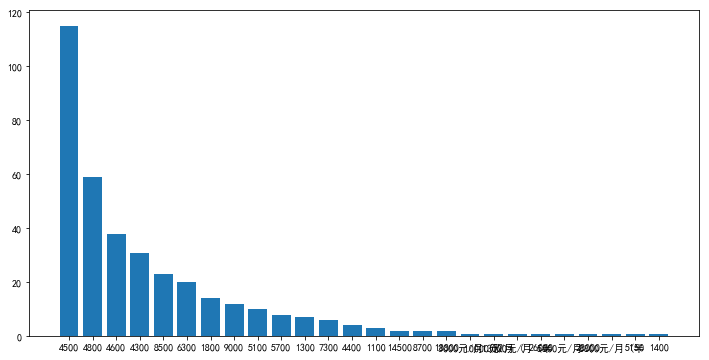

In [19]:
plt.figure(figsize=(12,6))
plt.bar(yuefu_name[::6],yuefu_price[::6])

In [20]:
# 将租金改为数值类型
# 通过正则表达是进行匹配
import re
price_list=[]
for x in data["RentPrice"]:
    s = re.findall(r'\d+',x)
    price_list.append(int(s[0]))

data["Price"] = price_list

In [21]:
data.head()

,Address,District,Community,Area,RentPrice,Layer,Shape,Toward,Release_Date,Rent_Period,...,Is_heater,Is_bed,Is_heating,Is_wifi,Is_closet,Is_gas,Is_img,Catch_time,date,Price
0,闵行,梅陇,梅陇二村,55,3850元/月 (季付价),低楼层/6层,1室1厅,南/北,17天前,1年以内,...,1,1,0,0,1,0,https://image1.ljcdn.com/lease-image/house/6dc...,2019-07-13 10:48:00,2019-07-13,3850
1,浦东,世博,六里二村,25,3700元/月 (季付价),高楼层/6层,1室1厅,南,22天前,1年以内,...,1,1,0,1,1,0,https://image1.ljcdn.com/lease-image/house/55d...,2019-07-13 10:48:00,2019-07-13,3700
2,浦东,南码头,光鸿苑,98,8000元/月 (季付价),高楼层/6层,3室2厅,南/北,1个月前,1年以内,...,1,1,0,0,1,0,https://image1.ljcdn.com/lease-image/house/4ef...,2019-07-13 10:48:00,2019-07-13,8000
3,闵行,春申,高兴花园,48,3500元/月 (季付价),中楼层/6层,1室1厅,南/北,10天前,1年以内,...,1,1,0,0,1,0,https://image1.ljcdn.com/lease-image/house/5cd...,2019-07-13 10:48:00,2019-07-13,3500
4,徐汇,徐家汇,乐山二村,33,5300元/月 (季付价),中楼层/6层,1室1厅,东南,11天前,1年以内,...,1,1,0,1,1,1,https://image1.ljcdn.com/lease-image/house/fad...,2019-07-13 10:48:00,2019-07-13,5300


### 对楼层数据类型进行整理
采集的楼层数据格式是‘x楼层/x层’，因为高中低楼层不能够定量表示，所以把楼层的格式拆分成两列，分别是类层所属的类别，以及楼层的具体层数

In [22]:
# 提取出低楼层、中楼层、高楼层
data['Layer']
layer_class = []
for i in data['Layer']:
    layer_class.append(i[:3])

In [23]:
# 提取出具体的楼层数
layer_floor = []
for i in data['Layer']:
    s = re.findall(r'\d+',i)
    layer_floor.append(int(s[0]))

In [24]:
# 添加到data中构成新的列
data['Layer_class'] = layer_class
data['Layer_floor'] = layer_floor
data.head()


,Address,District,Community,Area,RentPrice,Layer,Shape,Toward,Release_Date,Rent_Period,...,Is_heating,Is_wifi,Is_closet,Is_gas,Is_img,Catch_time,date,Price,Layer_class,Layer_floor
0,闵行,梅陇,梅陇二村,55,3850元/月 (季付价),低楼层/6层,1室1厅,南/北,17天前,1年以内,...,0,0,1,0,https://image1.ljcdn.com/lease-image/house/6dc...,2019-07-13 10:48:00,2019-07-13,3850,低楼层,6
1,浦东,世博,六里二村,25,3700元/月 (季付价),高楼层/6层,1室1厅,南,22天前,1年以内,...,0,1,1,0,https://image1.ljcdn.com/lease-image/house/55d...,2019-07-13 10:48:00,2019-07-13,3700,高楼层,6
2,浦东,南码头,光鸿苑,98,8000元/月 (季付价),高楼层/6层,3室2厅,南/北,1个月前,1年以内,...,0,0,1,0,https://image1.ljcdn.com/lease-image/house/4ef...,2019-07-13 10:48:00,2019-07-13,8000,高楼层,6
3,闵行,春申,高兴花园,48,3500元/月 (季付价),中楼层/6层,1室1厅,南/北,10天前,1年以内,...,0,0,1,0,https://image1.ljcdn.com/lease-image/house/5cd...,2019-07-13 10:48:00,2019-07-13,3500,中楼层,6
4,徐汇,徐家汇,乐山二村,33,5300元/月 (季付价),中楼层/6层,1室1厅,东南,11天前,1年以内,...,0,1,1,1,https://image1.ljcdn.com/lease-image/house/fad...,2019-07-13 10:48:00,2019-07-13,5300,中楼层,6


### 对户型的数据进行观察
通过柱状图分析可知户型的，基本上出租的户型是1室1厅，或者是2室1厅。可知出租的房子主要是针对**单身客户**或者是**好兄弟/姐妹客户**，也可能是**情侣客户**。具体客户信息由于没法采集，所以只能推断客户大部分是年轻人，主要是出来工作而租房。

1室1厅    790
2室1厅    732
2室2厅    446
3室2厅    236
1室0厅    170
3室1厅     95
2室0厅     74
1室2厅     67
4室2厅     34
5室2厅      9
3室0厅      5
4室1厅      3
5室3厅      2
3室3厅      1
7室2厅      1
6室3厅      1
Name: Shape, dtype: int64


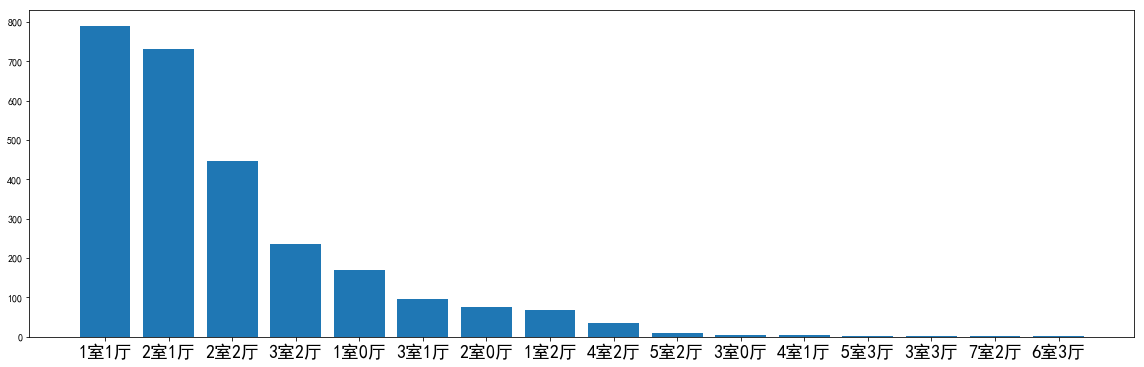

In [87]:
shape = data['Shape'].value_counts()
shape_class = shape.index
shape_class_amount = [x for x in shape[0:]]
print(shape)
plt.figure(figsize=(19.8,6))
plt.xticks(fontsize =18)
plt.bar(shape_class,shape_class_amount)
plt.savefig('image/shape_attri.png')

### 对朝向进行分析
房屋朝向关乎一个风水问题，同样也影响室内采光、通风、噪音等，大师们认为房屋朝向的优劣为以下的顺序：
**南->东南->东->西南->北->西**
由于采集的数据类别较为悬殊，只能看出朝南是最优的朝向。


In [26]:
data["Toward"].value_counts()

南         2089
南/北        307
北           63
东南          50
东           45
西           27
西南          18
西北          10
东北           9
东南/南         9
复式           6
东/南          6
跃层           5
南/西          4
南/西南         4
西/北          3
东/西          2
东/南/北        2
错层           2
西南/北         1
东/北          1
东南/西南        1
东/东南/南       1
东/东南         1
Name: Toward, dtype: int64

### 对发布日期进行分析
发布信息的类型比较特殊，当天发布的房屋信息其发布日期值是“今天”，而不是0天前，所以，先对“今天”进行转换，再提取所有发布日期的具体天数

In [27]:
data.loc[data["Release_Date"]=="今天",'Release_Date'] = 0
data["Release_Date"].value_counts()

1个月前     381
2天前      278
5天前      184
1天前      178
0        168
3天前      117
6天前      113
2个月前     110
4天前      101
7天前       82
13天前      68
9天前       66
12天前      60
3个月前      54
15天前      51
14天前      48
16天前      45
10天前      43
19天前      41
8天前       39
11天前      39
20天前      36
4个月前      34
22天前      31
18天前      31
21天前      30
26天前      26
23天前      26
17天前      20
27天前      19
24天前      19
29天前      17
7个月前      16
25天前      15
28天前      14
1年前       13
8个月前      13
5个月前      11
6个月前      11
9个月前      10
10个月前      5
11个月前      3
Name: Release_Date, dtype: int64

In [28]:
day_amount = []
for i in data["Release_Date"]:
    if i==0:
        day_amount.append(i)
        continue
        
    s = re.findall(r"\d+",str(i))[0]
#     print(s)
    if "月" in str(i):
        day_amount.append(int(s)*int(30))
    elif "年" in str(i):
        day_amount.append(int(s)*int(365))
    elif "天" in str(i):
        day_amount.append(int(s))
len(day_amount)

2666

In [29]:
data["Release_day_before"] = day_amount
data.head()

,Address,District,Community,Area,RentPrice,Layer,Shape,Toward,Release_Date,Rent_Period,...,Is_wifi,Is_closet,Is_gas,Is_img,Catch_time,date,Price,Layer_class,Layer_floor,Release_day_before
0,闵行,梅陇,梅陇二村,55,3850元/月 (季付价),低楼层/6层,1室1厅,南/北,17天前,1年以内,...,0,1,0,https://image1.ljcdn.com/lease-image/house/6dc...,2019-07-13 10:48:00,2019-07-13,3850,低楼层,6,17
1,浦东,世博,六里二村,25,3700元/月 (季付价),高楼层/6层,1室1厅,南,22天前,1年以内,...,1,1,0,https://image1.ljcdn.com/lease-image/house/55d...,2019-07-13 10:48:00,2019-07-13,3700,高楼层,6,22
2,浦东,南码头,光鸿苑,98,8000元/月 (季付价),高楼层/6层,3室2厅,南/北,1个月前,1年以内,...,0,1,0,https://image1.ljcdn.com/lease-image/house/4ef...,2019-07-13 10:48:00,2019-07-13,8000,高楼层,6,30
3,闵行,春申,高兴花园,48,3500元/月 (季付价),中楼层/6层,1室1厅,南/北,10天前,1年以内,...,0,1,0,https://image1.ljcdn.com/lease-image/house/5cd...,2019-07-13 10:48:00,2019-07-13,3500,中楼层,6,10
4,徐汇,徐家汇,乐山二村,33,5300元/月 (季付价),中楼层/6层,1室1厅,东南,11天前,1年以内,...,1,1,1,https://image1.ljcdn.com/lease-image/house/fad...,2019-07-13 10:48:00,2019-07-13,5300,中楼层,6,11


### 对租期的要求
因为缺失值达到50%以上，所以该列数据没有太大的价值

In [30]:
data["Rent_Period"].value_counts()

暂无数据     1844
1年以内      442
1~2年      229
2~3年      110
3年以上       30
1~3个月      11
Name: Rent_Period, dtype: int64

# 对房屋是否配有电梯进行分析
由于缺失值比较少，所以进行相应的插值
一般插值的方法有很多，如上下插值，平均值插值、中值插值以及算法插值
在下面我就用**随机森林**，训练房屋的面积、楼层的高度、租金等特征，对是否有电梯的特征的缺失值进行插补
如果最后数据训练的效果不理想，可能是在插值时考虑了设施配备的特征所导致的误差（先给自己挖个坑

In [31]:
print(data["Is_lift"].value_counts())
data.loc[data["Is_lift"]==0,'Is_lift'] = 2
data.loc[data["Is_lift"]=="暂无数据",'Is_lift']= 2

data["Is_lift"].value_counts()


无       1471
有       1053
暂无数据     142
Name: Is_lift, dtype: int64


无    1471
有    1053
2     142
Name: Is_lift, dtype: int64

In [32]:
data_copy = data.copy()

In [33]:
from sklearn.ensemble import RandomForestClassifier
df = data[['Area','Price','Layer_floor','Is_TV', 'Is_fridge', 'Is_washer', 'Is_air',
       'Is_heater', 'Is_bed', 'Is_heating', 'Is_wifi', 'Is_closet', 'Is_gas','Is_lift']]
# print(df.info())
df.loc[df['Is_lift']=='有','Is_lift'] = 1
df.loc[df['Is_lift']=='无','Is_lift'] = 0


df = df.astype(int)

df_trainset =  df[df['Is_lift']!=2]
df_xtrain = df_trainset[['Area','Price','Layer_floor','Is_TV', 'Is_fridge', 'Is_washer', 'Is_air',
                         'Is_heater', 'Is_bed', 'Is_heating', 'Is_wifi', 'Is_closet', 'Is_gas']]
df_ytrain  = df_trainset[['Is_lift']]
# print(df_xtrain.head())
df_xtrain_set = df_xtrain.astype(float)
df_ytrain_set = df_ytrain.astype(float)

df_test = df[df['Is_lift']==2]
df_test_x = df_test[['Area','Price','Layer_floor','Is_TV', 'Is_fridge', 'Is_washer', 'Is_air',
       'Is_heater', 'Is_bed', 'Is_heating', 'Is_wifi', 'Is_closet', 'Is_gas']]
df_test_y = df_test['Is_lift'].astype(float)

rf = RandomForestClassifier()
rf.fit(df_xtrain_set,df_ytrain_set)
res = rf.predict(df_test_x)
len(res)

E:\python\anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
E:\python\anaconda\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
E:\python\anaconda\lib\site-packages\ipykernel\__main__.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


142

In [34]:
data.loc[data['Is_lift']=='有','Is_lift'] = 1
data.loc[data['Is_lift']=='无','Is_lift'] = 0
data.loc[data['Is_lift']==2,'Is_lift'] = list(res)

In [89]:
data['Is_lift'].value_counts()

Is_lift
0.0     5.890146
1.0    18.499141
Name: Layer_floor, dtype: float64


0.0    1502
1.0    1164
Name: Is_lift, dtype: int64

In [36]:
data.head()

,Address,District,Community,Area,RentPrice,Layer,Shape,Toward,Release_Date,Rent_Period,...,Is_wifi,Is_closet,Is_gas,Is_img,Catch_time,date,Price,Layer_class,Layer_floor,Release_day_before
0,闵行,梅陇,梅陇二村,55,3850元/月 (季付价),低楼层/6层,1室1厅,南/北,17天前,1年以内,...,0,1,0,https://image1.ljcdn.com/lease-image/house/6dc...,2019-07-13 10:48:00,2019-07-13,3850,低楼层,6,17
1,浦东,世博,六里二村,25,3700元/月 (季付价),高楼层/6层,1室1厅,南,22天前,1年以内,...,1,1,0,https://image1.ljcdn.com/lease-image/house/55d...,2019-07-13 10:48:00,2019-07-13,3700,高楼层,6,22
2,浦东,南码头,光鸿苑,98,8000元/月 (季付价),高楼层/6层,3室2厅,南/北,1个月前,1年以内,...,0,1,0,https://image1.ljcdn.com/lease-image/house/4ef...,2019-07-13 10:48:00,2019-07-13,8000,高楼层,6,30
3,闵行,春申,高兴花园,48,3500元/月 (季付价),中楼层/6层,1室1厅,南/北,10天前,1年以内,...,0,1,0,https://image1.ljcdn.com/lease-image/house/5cd...,2019-07-13 10:48:00,2019-07-13,3500,中楼层,6,10
4,徐汇,徐家汇,乐山二村,33,5300元/月 (季付价),中楼层/6层,1室1厅,东南,11天前,1年以内,...,1,1,1,https://image1.ljcdn.com/lease-image/house/fad...,2019-07-13 10:48:00,2019-07-13,5300,中楼层,6,11


###  观察是否有停车位、用水情况、用电情况的特征
抓取数据的时候顺便抓取了这几个信息，特别是用水和用电情况，但从整体的结果上来看这几个特征的特征值并没有太大的价值

暂无数据    2627
免费使用      24
租用车位      15
Name: Is_parking, dtype: int64


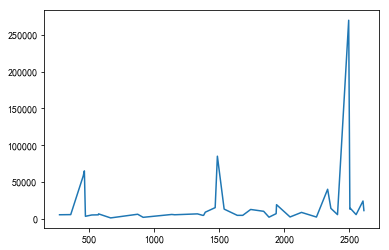

In [37]:
print(data['Is_parking'].value_counts())
free_parking = data[data['Is_parking']!='暂无数据']
grouped = free_parking['Price'].groupby(free_parking['Is_parking'])
grouped.mean()
plt.plot(free_parking['Price'])

In [38]:
data['water_way'].value_counts()

民水      2568
暂无数据      74
商水        24
Name: water_way, dtype: int64

In [39]:
data['electricity_way'].value_counts()

民电      2569
暂无数据      73
商电        24
Name: electricity_way, dtype: int64

## 交通出行方面
* 采集的时候我采集的数据是房屋周围的地铁站数目以及距离最近地铁站的距离
* 之前通过整体的数据观察也是发现了一些信息，房屋信息中存在一些虚假信息，比如地铁线路数目超过16条等，我认为这些是不合理的，但是通过个案进行分析，发现确实有这样的房屋

In [40]:
data['Subwayline_Number'].value_counts()

0     692
1     659
2     588
3     401
4     223
5      58
6      32
7       6
8       3
11      2
15      1
18      1
Name: Subwayline_Number, dtype: int64

In [41]:
print(len(data[data['Subwayline_Number']>=7]))
print(data[data['Subwayline_Number']==18])
data[data['Subwayline_Number']>=7]

13
    Address District  Community  Area RentPrice   Layer Shape Toward  \
958      松江       泗泾  法兰西世家(别墅)   190  7000元/月   低楼层/3层  5室2厅    南/北   

    Release_Date Rent_Period  ...  Is_wifi Is_closet Is_gas  \
958         2个月前        暂无数据  ...        0         0      0   

                                                Is_img          Catch_time  \
958  https://image1.ljcdn.com/shfdfs-image/20171217... 2019-07-13 12:42:00   

           date  Price  Layer_class  Layer_floor  Release_day_before  
958  2019-07-13   7000          低楼层            3                  60  

[1 rows x 33 columns]


,Address,District,Community,Area,RentPrice,Layer,Shape,Toward,Release_Date,Rent_Period,...,Is_wifi,Is_closet,Is_gas,Is_img,Catch_time,date,Price,Layer_class,Layer_floor,Release_day_before
115,徐汇,万体馆,天钥新村,40,5000元/月 (季付价),中楼层/5层,1室1厅,南,2天前,暂无数据,...,1,1,1,https://image1.ljcdn.com/310000-inspection/4bc...,2019-07-13 11:02:00,2019-07-13,5000,中楼层,5,2
138,徐汇,斜土路,西木小区,38,4300元/月,高楼层/6层,1室0厅,南,4天前,暂无数据,...,0,0,0,http://vrlab-image.ljcdn.com/release/vradmin/1...,2019-07-13 11:04:00,2019-07-13,4300,高楼层,6,4
508,闵行,龙柏,龙柏四村,100,7500元/月 (季付价),高楼层/6层,2室2厅,南,2天前,1年以内,...,0,1,1,https://image1.ljcdn.com/310000-inspection/84c...,2019-07-13 12:02:00,2019-07-13,7500,高楼层,6,2
535,徐汇,斜土路,西木小区,38,5000元/月,低楼层/6层,1室1厅,南,1天前,暂无数据,...,0,0,0,http://vrlab-image.ljcdn.com/release/vradmin/1...,2019-07-13 12:04:00,2019-07-13,5000,低楼层,6,1
604,普陀,光新,光新苑,56,4800元/月,中楼层/7层,2室0厅,南/北,5天前,暂无数据,...,0,0,0,https://image1.ljcdn.com/hdic-frame/761b7fd8-2...,2019-07-13 12:11:00,2019-07-13,4800,中楼层,7,5
720,徐汇,龙华,东航小区,40,5200元/月 (季付价),低楼层/4层,2室1厅,南,1个月前,1年以内,...,1,1,1,https://image1.ljcdn.com/310000-inspection/f61...,2019-07-13 12:21:00,2019-07-13,5200,低楼层,4,30
932,闸北,西藏北路,北市场小区,36,4800元/月,高楼层/7层,1室1厅,南,3个月前,暂无数据,...,0,0,0,http://vrlab-image.ljcdn.com/release/auto3dhd/...,2019-07-13 12:40:00,2019-07-13,4800,高楼层,7,90
958,松江,泗泾,法兰西世家(别墅),190,7000元/月,低楼层/3层,5室2厅,南/北,2个月前,暂无数据,...,0,0,0,https://image1.ljcdn.com/shfdfs-image/20171217...,2019-07-13 12:42:00,2019-07-13,7000,低楼层,3,60
974,徐汇,万体馆,天钥新村,43,5300元/月 (季付价),高楼层/6层,1室1厅,南,16天前,1年以内,...,1,1,0,https://image1.ljcdn.com/310000-inspection/dd6...,2019-07-13 12:43:00,2019-07-13,5300,高楼层,6,16
976,闸北,西藏北路,北市场小区,18,3000元/月,高楼层/7层,1室0厅,西/北,20天前,暂无数据,...,0,0,0,https://image1.ljcdn.com/310000-inspection/1f3...,2019-07-13 12:44:00,2019-07-13,3000,高楼层,7,20


## 房屋配套设施
根据链家网房屋信息主页给出的配备设施信息，我抓取了其中的房屋设施的信息，并且认为配备的设施会影响房屋的售价
链家网给出的设施类型有10种，分别是**电视、冰箱、洗衣机、空调、热水器、床、暖气、宽带、衣柜、天然气**
在前面的整体数据中我发现这些配备的均值为0.3，即绝大多数的房间是不配备上述的设备，但觉得并不合理，于是进一步分析

In [42]:
data.describe()

,Area,Is_lift,Subwayline_Number,Subway_Distance,Is_TV,Is_fridge,Is_washer,Is_air,Is_heater,Is_bed,Is_heating,Is_wifi,Is_closet,Is_gas,Price,Layer_floor,Release_day_before
count,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000
mean,70.973368,0.436609,1.700300,390.617029,0.255064,0.303451,0.300825,0.311328,0.304951,0.311703,0.133908,0.166542,0.309077,0.270818,6091.601650,11.395349,23.786197
std,43.374157,0.496058,1.544771,347.469262,0.435979,0.459834,0.458703,0.463123,0.460473,0.463276,0.340618,0.372636,0.462200,0.444465,7187.327595,8.223321,46.261838
min,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1000.000000,1.000000,0.000000
25%,45.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3800.000000,6.000000,3.000000
50%,62.000000,0.000000,1.000000,353.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5000.000000,6.000000,10.000000
75%,89.000000,1.000000,3.000000,668.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,6800.000000,16.000000,29.000000
max,1236.000000,1.000000,18.000000,1189.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,270000.000000,49.000000,365.000000


In [43]:
grouped = data['Price'].groupby(data['Is_bed'])
grouped.mean()

Is_bed
0    5735.710627
1    6877.474128
Name: Price, dtype: float64

In [44]:
df = data[data['Price']>10000]
print(df['Is_bed'].value_counts())
grouped = df['Price'].groupby(df['Is_bed'])
grouped.mean()

0    108
1     93
Name: Is_bed, dtype: int64


Is_bed
0    20638.888889
1    16209.548387
Name: Price, dtype: float64

In [45]:
# 观察配有所有的设施的数据
df = data.loc[(data['Is_TV']==1) &(data['Is_fridge']==1)&(data['Is_washer']==1)&(data['Is_air']==1)&(data['Is_heater']==1)&(data['Is_bed']==1)&(data['Is_heating']==1)
             &(data['Is_wifi']==1)&(data['Is_closet']==1)&(data['Is_gas']==1)]
df.describe()

,Area,Is_lift,Subwayline_Number,Subway_Distance,Is_TV,Is_fridge,Is_washer,Is_air,Is_heater,Is_bed,Is_heating,Is_wifi,Is_closet,Is_gas,Price,Layer_floor,Release_day_before
count,297.000000,297.000000,297.000000,297.000000,297.0,297.0,297.0,297.0,297.0,297.0,297.0,297.0,297.0,297.0,297.000000,297.000000,297.000000
mean,72.060606,0.498316,2.181818,405.734007,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8064.814815,13.828283,24.050505
std,46.335837,0.500841,1.594100,319.825427,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7353.539508,9.984488,38.164661
min,19.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1600.000000,1.000000,0.000000
25%,44.000000,0.000000,1.000000,110.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4700.000000,6.000000,4.000000
50%,58.000000,0.000000,2.000000,376.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,6300.000000,7.000000,15.000000
75%,89.000000,1.000000,3.000000,627.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8500.000000,22.000000,30.000000
max,425.000000,1.000000,11.000000,1170.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,85000.000000,40.000000,365.000000


In [46]:
# 观察没有任何设备的数据
df_not = data.loc[(data['Is_TV']==0) &(data['Is_fridge']==0)&(data['Is_washer']==0)&(data['Is_air']==0)&(data['Is_heater']==0)&(data['Is_bed']==0)&(data['Is_heating']==0)
             &(data['Is_wifi']==0)&(data['Is_closet']==0)&(data['Is_gas']==0)]
df_not.describe()

,Area,Is_lift,Subwayline_Number,Subway_Distance,Is_TV,Is_fridge,Is_washer,Is_air,Is_heater,Is_bed,Is_heating,Is_wifi,Is_closet,Is_gas,Price,Layer_floor,Release_day_before
count,1801.000000,1801.000000,1801.000000,1801.000000,1801.0,1801.0,1801.0,1801.0,1801.0,1801.0,1801.0,1801.0,1801.0,1801.0,1801.000000,1801.000000,1801.000000
mean,71.018323,0.434203,1.519711,382.837868,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5533.108828,10.954470,22.002776
std,35.380051,0.495790,1.482406,355.375833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4736.732034,7.691058,44.944218
min,12.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.000000,1.000000,0.000000
25%,47.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3600.000000,6.000000,2.000000
50%,64.000000,0.000000,1.000000,337.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4700.000000,6.000000,8.000000
75%,89.000000,1.000000,2.000000,668.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6300.000000,14.000000,26.000000
max,434.000000,1.000000,18.000000,1189.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,110000.000000,49.000000,365.000000


### 通过将配套设施分为两类，一类是设备齐全，另一类是无任何设备，通过describe函数返回的数据中可以发现：
* 房屋的面积、均值、上中下四分数、最小值最大值并没有太大的差别
* 是否配有电梯等其他硬件设置数据也没有太大差异
* 配套齐全的房屋的平均月租金比无任何设施的月租金高出2500块

结论：链家网上的配套设施并**不是**完全准确的，19平米的房子或是1600月租的房子不可能有任何设备，而434平米的房子或是月租金1W多的房屋不可能没有设备，因此，在之后训练模型时，对这部分数据要进行分层次训练或者是舍弃的处理

In [47]:
# 分层的意思是以房价为标准，对房屋数据进行分层，但实际上效果并不理想，数据中呈现出来的分布明显不符合实际情况
# 最基本的设施床在4500到6000的月租金的房屋信息中均值竟然只有0.3，感觉不合理啊
df_price = data[(data['Price']>4500)&(data['Price']<6000)]
df_price.describe()

,Area,Is_lift,Subwayline_Number,Subway_Distance,Is_TV,Is_fridge,Is_washer,Is_air,Is_heater,Is_bed,Is_heating,Is_wifi,Is_closet,Is_gas,Price,Layer_floor,Release_day_before
count,644.000000,644.000000,644.000000,644.000000,644.000000,644.000000,644.000000,644.000000,644.000000,644.000000,644.000000,644.000000,644.000000,644.000000,644.000000,644.000000,644.000000
mean,62.850932,0.310559,1.863354,428.336957,0.253106,0.322981,0.321429,0.322981,0.321429,0.329193,0.119565,0.152174,0.322981,0.273292,5189.391304,9.374224,17.442547
std,27.339854,0.463082,1.558589,342.068786,0.435129,0.467979,0.467388,0.467979,0.467388,0.470285,0.324705,0.359469,0.467979,0.445996,379.178668,6.424440,30.343879
min,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4600.000000,1.000000,0.000000
25%,43.750000,0.000000,1.000000,43.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4800.000000,6.000000,2.000000
50%,57.000000,0.000000,2.000000,441.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5200.000000,6.000000,9.000000
75%,77.000000,1.000000,3.000000,714.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,5500.000000,11.000000,22.250000
max,349.000000,1.000000,11.000000,1181.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5900.000000,36.000000,365.000000


In [48]:
# 将数据暂时保存一下
data.to_csv('house_before.csv',encoding='gbk',index=False)

## 地理位置对房价有影响
由于在采集数据的时候，房屋所在的地址是字符串类型的，不容易**编码量化**，但对于房价等信息而言，房屋所在的位置会有较大的影响，所以，我调用**百度API**进行地址逆解析，将房屋所在的经纬度以及小区的类型返回，通过这种方式量化地理位置特征

In [59]:
import requests
import json
line1 = data.loc[0,'Address']+data.loc[0,'District']+data.loc[0,'Community']
# baiduUrl = "http://api.map.baidu.com/geocoder/v2/?ak=Al6Gc6g4ocO92u5zMdI1OKxkIUoX72S6&address=%s&output=json"%(line1)
# baiduUrl = "http://api.map.baidu.com/geocoder/v2/?ak=cblUEIlTU9TandkDPtz2lFBN7yc8Q4Yh&address=%s&output=json"%(line1)
baiduUrl = "http://api.map.baidu.com/geocoding/v3/?address=%s&output=json&ak=cblUEIlTU9TandkDPtz2lFBN7yc8Q4Yh"%(line1)
# line1
req = requests.get(baiduUrl)
content = req.text
print(content)
baiduAddr = json.loads(content)

{"status":0,"result":{"location":{"lng":121.41768287765956,"lat":31.140108722155206},"precise":0,"confidence":30,"comprehension":100,"level":"地产小区"}}


In [71]:
import requests
import json
# lng_list = []
# lat_list = []
# level_list = []
for i in range(2580,len(data)):
    line1 = data.loc[i,'Address']+data.loc[i,'District']+data.loc[i,'Community']
    baiduUrl = "http://api.map.baidu.com/geocoding/v3/?address=%s&output=json&ak=cblUEIlTU9TandkDPtz2lFBN7yc8Q4Yh"%(line1)
    req = requests.get(baiduUrl)
    content = req.text
    baiduAddr = json.loads(content)
    lng = baiduAddr["result"]["location"]["lng"]
    lat = baiduAddr["result"]["location"]["lat"]
    level = baiduAddr["result"]["level"]
    lng_list.append(float(lng))
    lat_list.append(float(lat))
    level_list.append(level)
    if i%500==0:
        time.sleep(5)
    
# print(type(content))
# print(content[:-1])

# # print(baiduAddr)
# # print(type(baiduAddr))

# print(lng,lat,level)


In [72]:
lat_list_copy = lat_list
lng_list_copy = lng_list
len(lat_list)
len(lng_list)

2666

In [73]:
# 将经纬度添加到数据集中
data['lng'] = lng_list
data['lat'] = lat_list
data['level'] = level_list

In [74]:
data.head()

,Address,District,Community,Area,RentPrice,Layer,Shape,Toward,Release_Date,Rent_Period,...,Is_img,Catch_time,date,Price,Layer_class,Layer_floor,Release_day_before,lng,lat,level
0,闵行,梅陇,梅陇二村,55,3850元/月 (季付价),低楼层/6层,1室1厅,南/北,17天前,1年以内,...,https://image1.ljcdn.com/lease-image/house/6dc...,2019-07-13 10:48:00,2019-07-13,3850,低楼层,6,17,121.417683,31.140109,地产小区
1,浦东,世博,六里二村,25,3700元/月 (季付价),高楼层/6层,1室1厅,南,22天前,1年以内,...,https://image1.ljcdn.com/lease-image/house/55d...,2019-07-13 10:48:00,2019-07-13,3700,高楼层,6,22,116.543093,23.577147,UNKNOWN
2,浦东,南码头,光鸿苑,98,8000元/月 (季付价),高楼层/6层,3室2厅,南/北,1个月前,1年以内,...,https://image1.ljcdn.com/lease-image/house/4ef...,2019-07-13 10:48:00,2019-07-13,8000,高楼层,6,30,121.522336,31.206077,地产小区
3,闵行,春申,高兴花园,48,3500元/月 (季付价),中楼层/6层,1室1厅,南/北,10天前,1年以内,...,https://image1.ljcdn.com/lease-image/house/5cd...,2019-07-13 10:48:00,2019-07-13,3500,中楼层,6,10,121.408940,31.117246,地产小区
4,徐汇,徐家汇,乐山二村,33,5300元/月 (季付价),中楼层/6层,1室1厅,东南,11天前,1年以内,...,https://image1.ljcdn.com/lease-image/house/fad...,2019-07-13 10:48:00,2019-07-13,5300,中楼层,6,11,121.436942,31.203144,地产小区


In [75]:
# 将数据保存下来
data.to_csv('house_whole_info.csv',encoding='gbk',index=False)

E:\python\anaconda\lib\site-packages\seaborn\categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


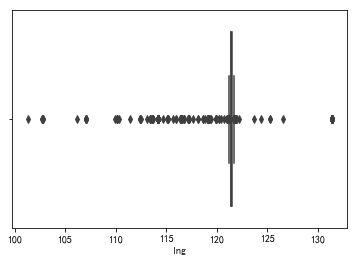

In [442]:
# 检测经纬度是否有异常值
sns.boxplot(x = data['lng'],data=data)

(array([5.000e+00, 8.000e+00, 5.000e+00, 7.000e+00, 5.800e+01, 5.800e+01,
        2.494e+03, 4.000e+00, 1.000e+00, 2.600e+01]),
 array([101.28042055, 104.29311601, 107.30581148, 110.31850694,
        113.33120241, 116.34389787, 119.35659333, 122.3692888 ,
        125.38198426, 128.39467972, 131.40737519]),
 <a list of 10 Patch objects>)

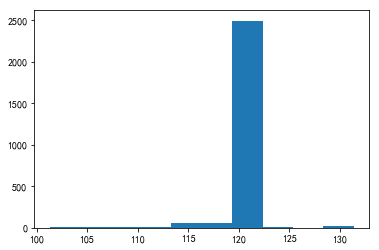

In [443]:
plt.hist(data['lng'])

In [445]:
# 查看小区类型,可以看出基本都是地产小区
data['level'].value_counts()

地产小区       1674
UNKNOWN     237
道路          231
区县          189
商圈          115
商务大厦         68
餐饮           41
旅游景点         27
村庄           26
城市           25
火车站          10
乡镇            8
购物            5
宾馆            4
休闲娱乐          3
工业园区          2
生活服务          1
Name: level, dtype: int64

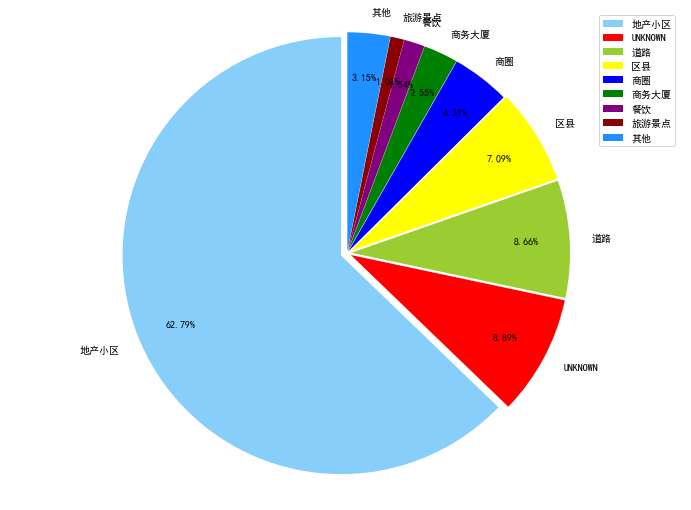

In [110]:
plt.figure(figsize=(12,9))
labels = [u'地产小区',u'UNKNOWN',u'道路',u'区县',u'商圈',u'商务大厦',u'餐饮',u'旅游景点',u'其他']
sizes = [1674,237,231,189,115,68,41,27,84]
colors = ['lightskyblue','red','yellowgreen','yellow','blue','green','purple','darkred','dodgerblue']
explode = (0.03,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01)
patcher,text1,text2 = plt.pie(sizes,explode = explode,labels = labels,colors = colors,autopct = '%3.2f%%',
                             shadow = False,startangle = 90,pctdistance =0.8)
plt.axis('equal')
plt.legend()
plt.savefig('image/level_pie.png')
plt.show()

## 探索性数据分析

## 房屋地理位置分布图

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy import interpolate
color = sns.color_palette()
%matplotlib inline
import sys
import importlib
importlib.reload(sys)
mpl.rcParams['font.sans-serif'] = ['SimHei']

import folium
import webbrowser
from folium.plugins import HeatMap

In [2]:
data = pd.read_csv('house_whole_info.csv',encoding='gbk')
data.describe()

,Area,Is_lift,Subwayline_Number,Subway_Distance,Is_TV,Is_fridge,Is_washer,Is_air,Is_heater,Is_bed,Is_heating,Is_wifi,Is_closet,Is_gas,Price,Layer_floor,Release_day_before,lng,lat
count,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000
mean,70.973368,0.436609,1.700300,390.617029,0.255064,0.303451,0.300825,0.311328,0.304951,0.311703,0.133908,0.166542,0.309077,0.270818,6091.601650,11.395349,23.786197,121.201037,31.286480
std,43.374157,0.496058,1.544771,347.469262,0.435979,0.459834,0.458703,0.463123,0.460473,0.463276,0.340618,0.372636,0.462200,0.444465,7187.327595,8.223321,46.261838,2.031952,2.358816
min,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1000.000000,1.000000,0.000000,101.280421,20.077154
25%,45.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3800.000000,6.000000,3.000000,121.389156,31.159306
50%,62.000000,0.000000,1.000000,353.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5000.000000,6.000000,10.000000,121.450998,31.218947
75%,89.000000,1.000000,3.000000,668.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,6800.000000,16.000000,29.000000,121.514844,31.276329
max,1236.000000,1.000000,18.000000,1189.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,270000.000000,49.000000,365.000000,131.407375,46.583598


In [3]:
lat = np.array(data['lat'])
lng = np.array(data['lng'])
df_heat = [[lat[i],lng[i]] for i in range(len(lat))]
map_osm = folium.Map(location= [35,130],zoom_start = 5)
HeatMap(df_heat).add_to(map_osm)
file_path = r"image/heatmap.html"
map_osm.save(file_path)

In [4]:
file_path = r"image/heatmap.html"
map_osm.save(file_path)

In [11]:
import os
import webbrowser
import sys
lng = data['lng']
lat = data['lat']
location = np.vstack([lng,lat]).T
m = folium.Map([35,130],zoom_start=  5)
route = folium.PolyLine(
        location,
        weight = 1,
        color = 'red',
        ).add_to(m)

map_loc = []
k=0
for i in range(len(lng)):
    if i%5==0:
        k = k+1
        map_loc.append([lat[i],lng[i]])
        folium.Marker([lat[i],lng[i]], popup='<i>'+str(k)+'</i>').add_to(m)

map_loc = np.array(map_loc)
m.save('image/point_map.html')


## 看看上海可出租的最高楼层在哪里？

In [434]:

u = np.argmax(data['Layer_floor'])
data.loc[u,"Community"]

E:\python\anaconda\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


'汤臣一品'

Address
嘉定    3875.961538
奉贤    2390.625000
宝山    4481.962025
徐汇    6778.003390
普陀    5730.386740
杨浦    5739.440994
松江    4263.245033
浦东    6063.757396
虹口    5805.511811
金山    1300.000000
长宁    9637.804878
闵行    5207.801418
闸北    7344.949495
青浦    4707.475000
静安    8310.000000
黄浦    8907.241379
Name: Price, dtype: float64


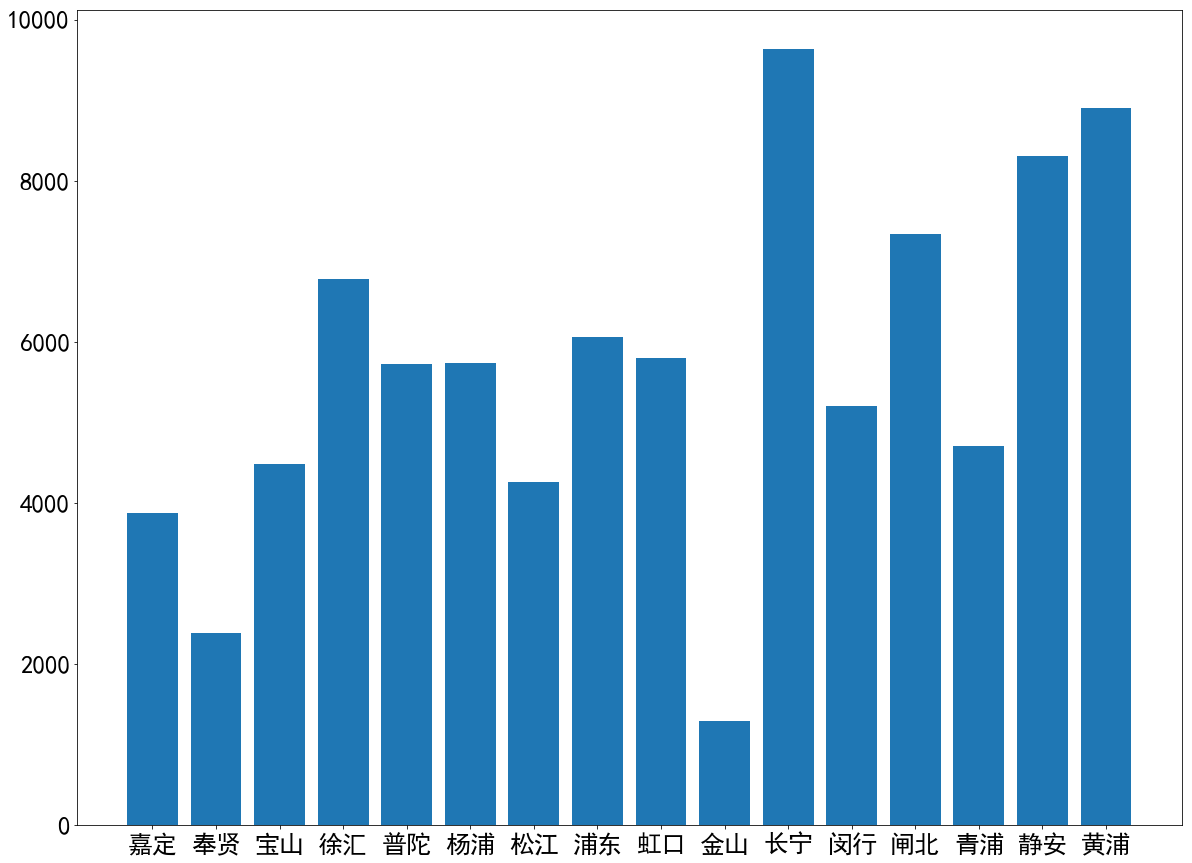

In [29]:
grouped = data['Price'].groupby(data['Address'])
print(grouped.mean())
address_name = list(grouped.mean().index)
address_price = [int(x) for x in grouped.mean()[0:]]
# print(address_price)
plt.figure(figsize=(19.8,15))
plt.xticks(fontsize = 25)
plt.yticks(fontsize=25)
plt.bar(address_name,address_price)
plt.savefig('image/address_price.png')

Text(0.5,1,'Price Attribution')

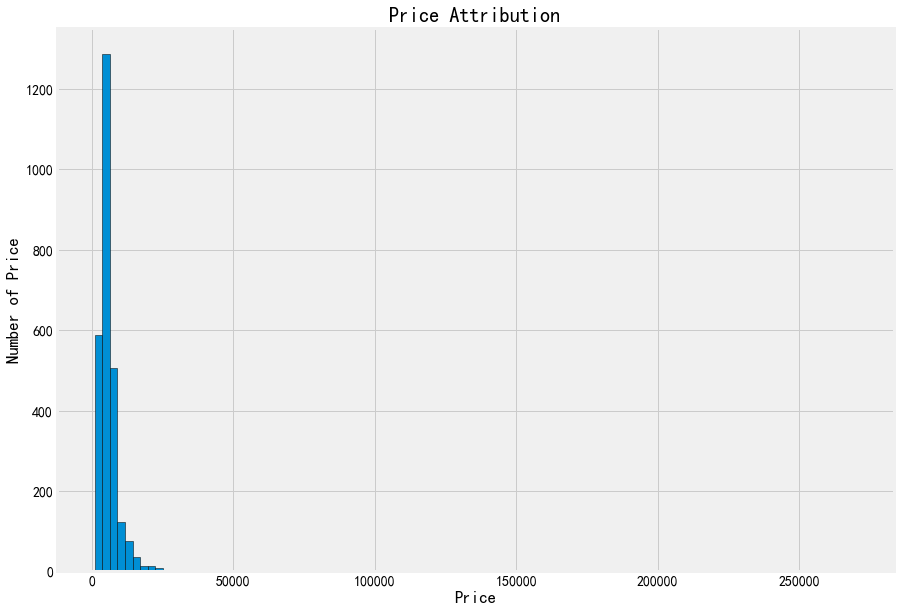

In [32]:
# 画出来的图发现租金有达到27W的，而上四分数才在6000左右
plt.figure(figsize=(15,10))
plt.style.use('fivethirtyeight')
plt.hist(data['Price'],bins=100,edgecolor = 'k')
plt.xlabel('Price')
plt.ylabel('Number of Price')
plt.title('Price Attribution')

13


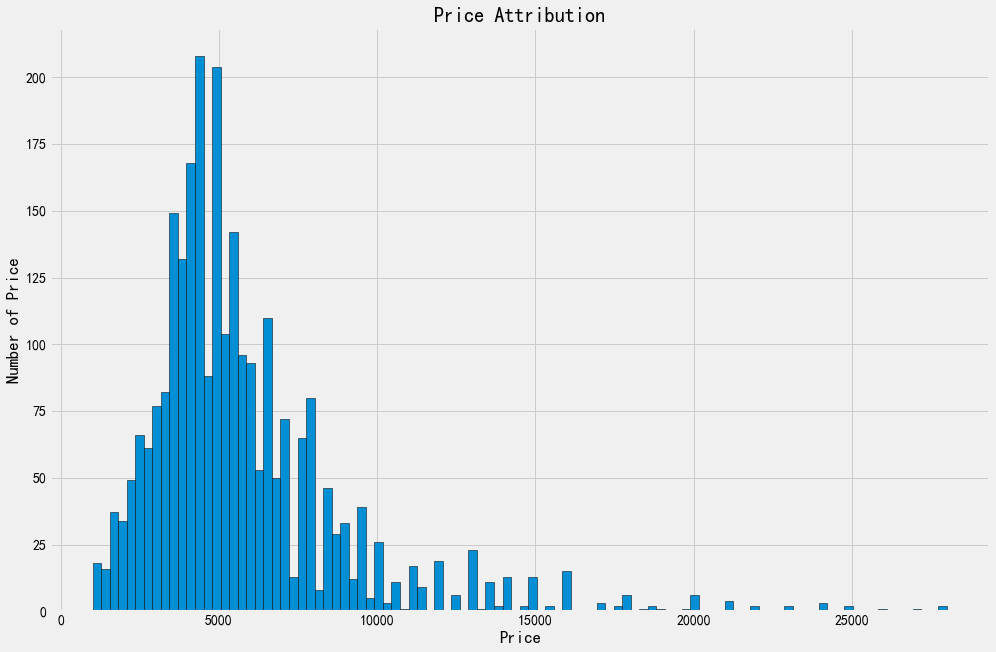

In [36]:
print(len(data[data['Price']>30000]))
df = data[data['Price']<30000]
plt.figure(figsize=(15,10))
plt.style.use('fivethirtyeight')
plt.hist(df['Price'],bins=100,edgecolor = 'k')
plt.xlabel('Price')
plt.ylabel('Number of Price')
plt.title('Price Attribution')
plt.savefig('image/Price_Attri.png')

In [436]:
price_ = data['Price'].value_counts()
price_name = price_.index
price_amount= [x for x in price_[0:]]
# price_amount

13


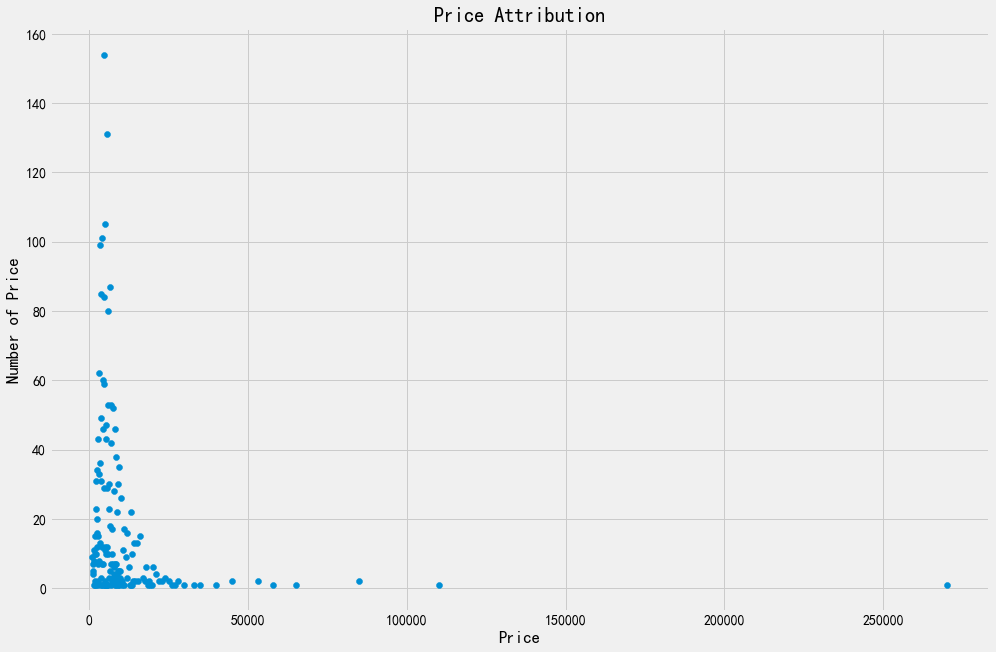

In [40]:
print(len(data[data['Price']>30000]))
df = data[data['Price']<30000]
plt.figure(figsize=(15,10))
plt.scatter(price_name,price_amount)
plt.xlabel('Price')
plt.ylabel('Number of Price')
plt.title('Price Attribution')
plt.savefig('image/Price_Attri.png')

E:\python\anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
E:\python\anaconda\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


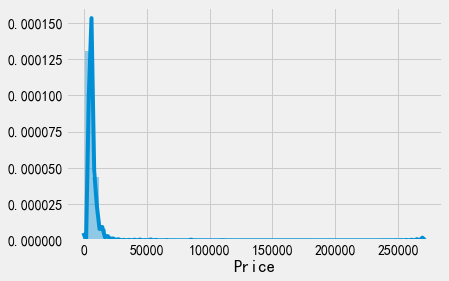

In [41]:
sns.distplot(data['Price'])

In [42]:
print("Skewness: %f" % data['Price'].skew())# 偏度
print("Kurtosis: %f" % data['Price'].kurt())# 峰度
# 价格的分布呈现正偏态，偏度大于0，即大部分的房屋组价都在5000左右，只有极少数上万块
# 具有正峰度的分布，有更重的尾部，例如t分布

Skewness: 21.672523
Kurtosis: 713.545602


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 36 columns):
Address               2666 non-null object
District              2666 non-null object
Community             2666 non-null object
Area                  2666 non-null int64
RentPrice             2666 non-null object
Layer                 2666 non-null object
Shape                 2666 non-null object
Toward                2666 non-null object
Release_Date          2666 non-null object
Rent_Period           2666 non-null object
Is_lift               2666 non-null float64
Is_parking            2666 non-null object
water_way             2666 non-null object
electricity_way       2666 non-null object
Subwayline_Number     2666 non-null int64
Subway_Distance       2666 non-null int64
Is_TV                 2666 non-null int64
Is_fridge             2666 non-null int64
Is_washer             2666 non-null int64
Is_air                2666 non-null int64
Is_heater             2666 non-null int

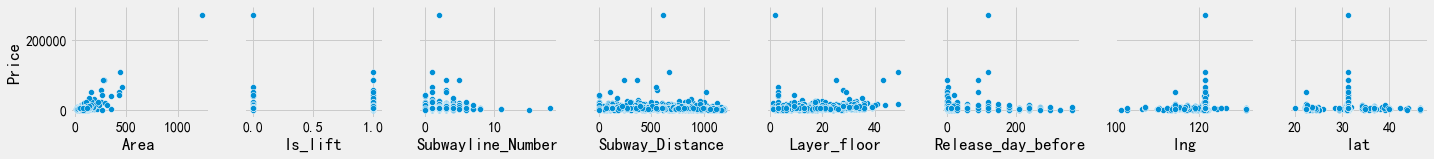

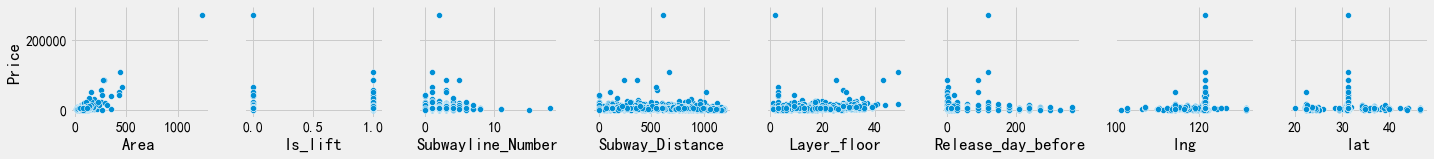

In [63]:
data.info()
# df = data[['Area','Is_lift','Subwayline_Number','Subway_Distance','Layer_floor','Release_day_before','lng','lat']]
# figure = plt.figure()
sns.pairplot(x_vars=['Area','Is_lift','Subwayline_Number','Subway_Distance','Layer_floor',
                     'Release_day_before','lng','lat'],y_vars=['Price'],data=data)
sns_plot = sns.pairplot(x_vars=['Area','Is_lift','Subwayline_Number','Subway_Distance','Layer_floor',
                     'Release_day_before','lng','lat'],y_vars=['Price'],data=data)
sns_plot.savefig('image/pair_price.png')

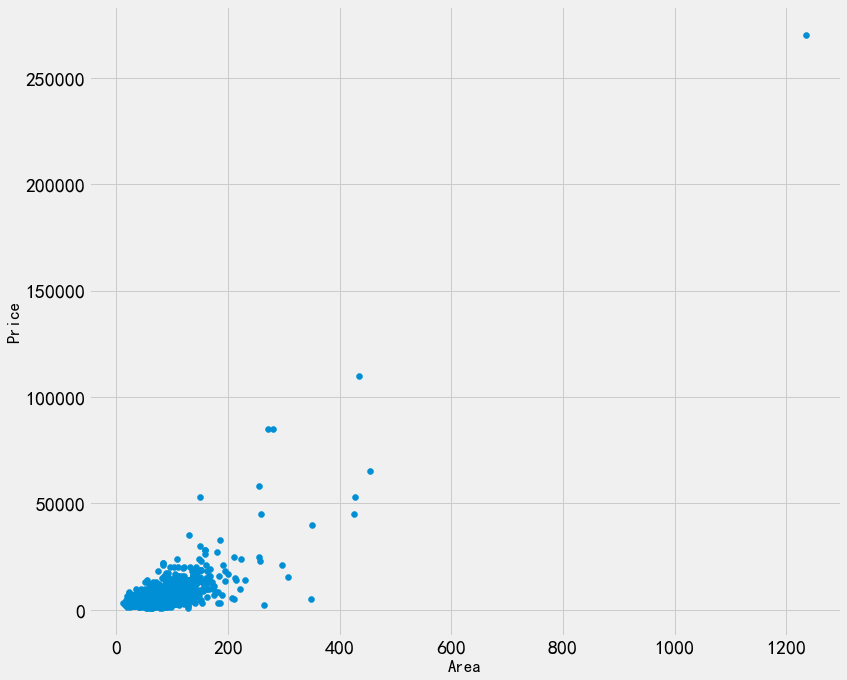

In [62]:
# 不难看出，房屋的面积与房价呈现较强的线性关系
var = 'Area'
plt.figure(figsize=(12,10.8))
df = pd.concat([data['Price'],data[var]],axis=1)
plt.scatter(x=var,y='Price',data=data)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Area')
plt.ylabel('Price')
plt.savefig('image/Price_Area')

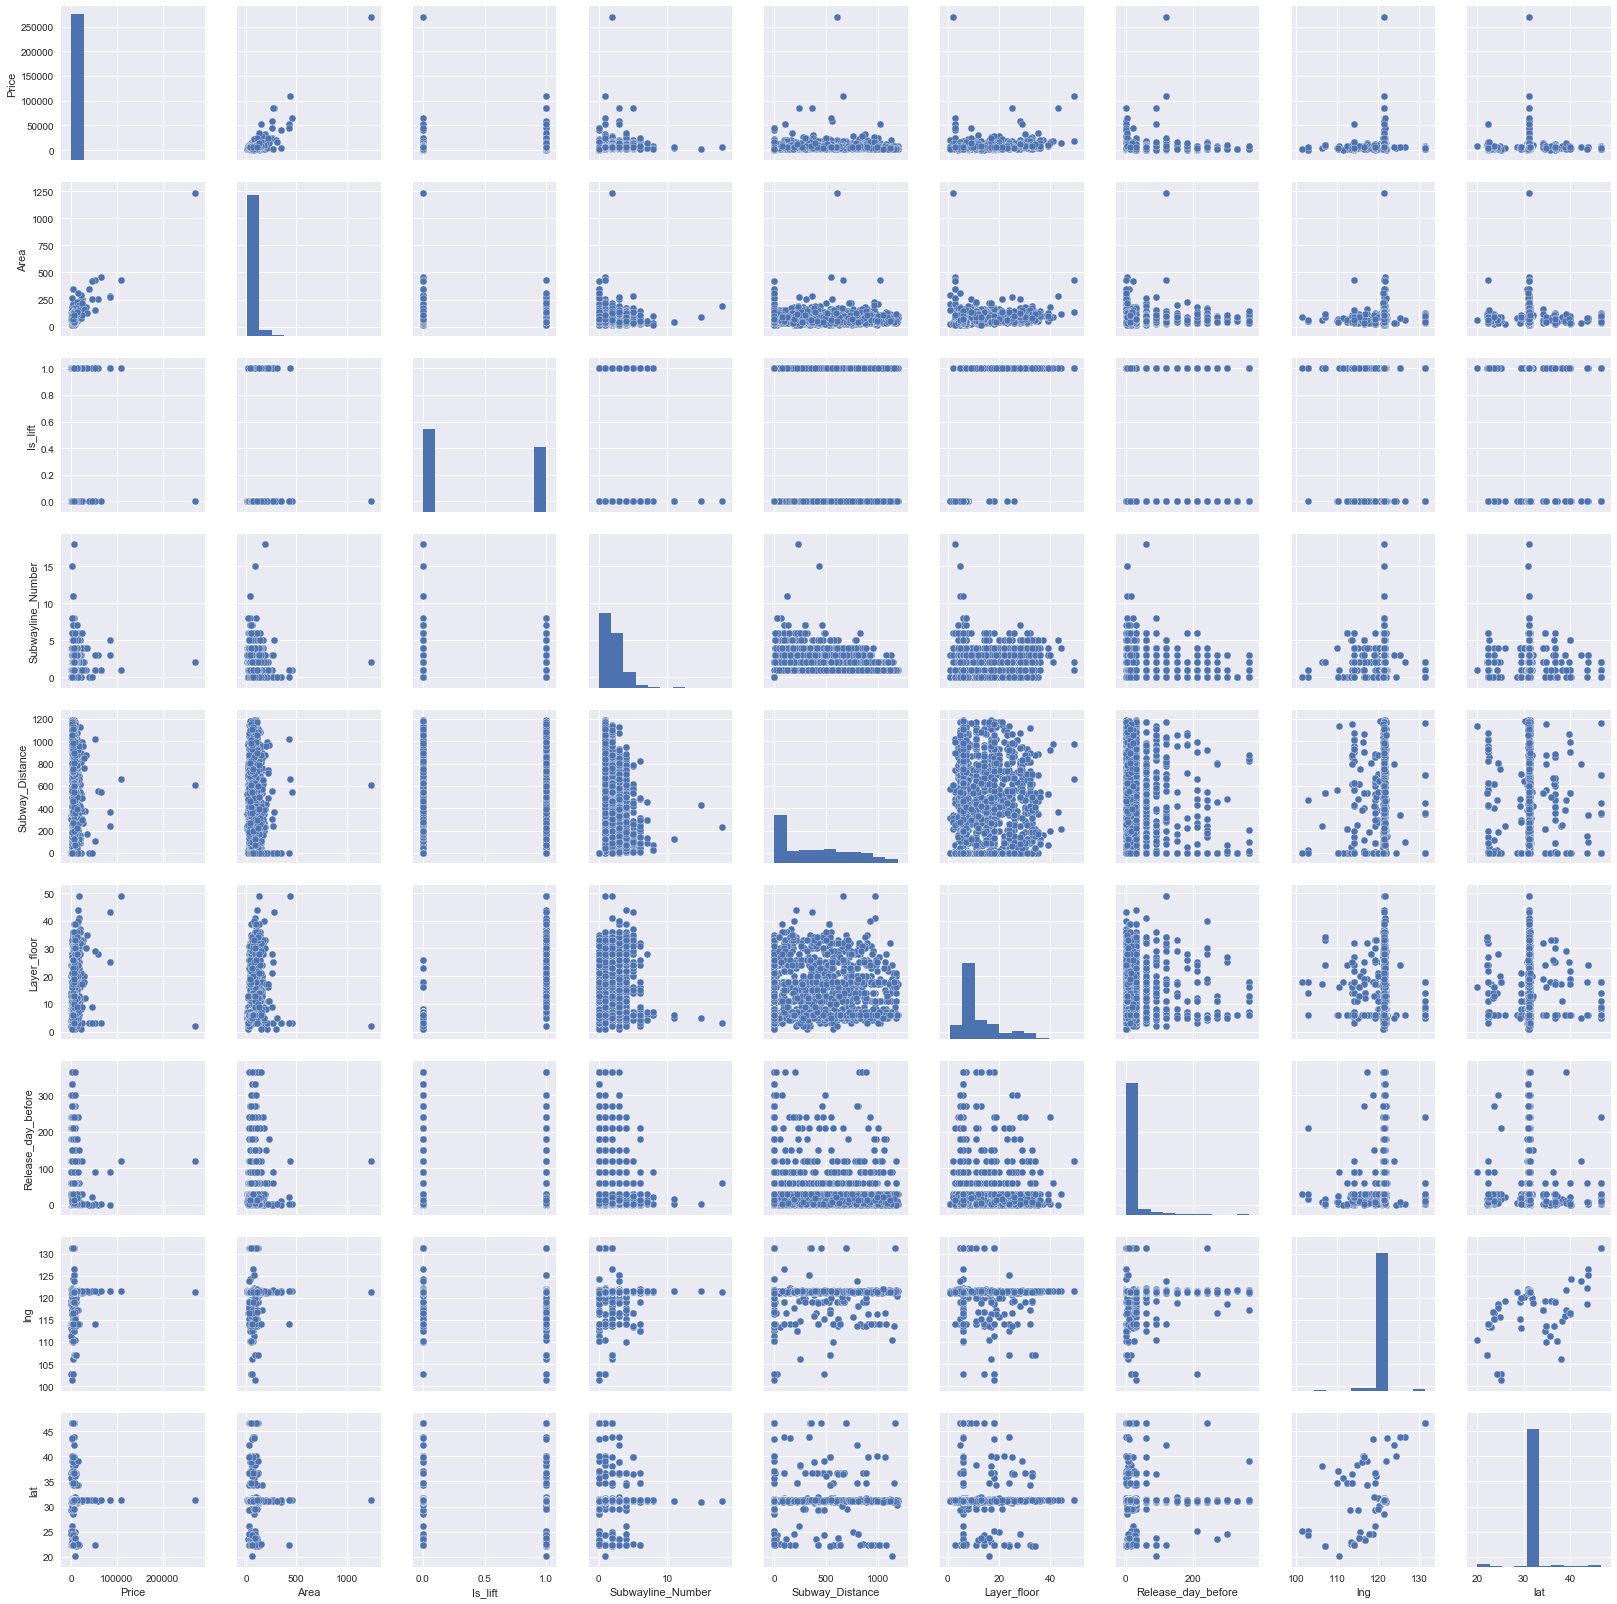

In [69]:
sns.set()
cols = ['Price','Area','Is_lift','Subwayline_Number','Subway_Distance','Layer_floor','Release_day_before','lng','lat']
sns.pairplot(data[cols], size = 2.5)
plt.show()

In [78]:
# 探究特征与目标之间的关系
data_set = data[data['Price']<20000]
shape_list = data_set['Shape'].value_counts()
types = list(shape_list.index)
print(types)

['1室1厅', '2室1厅', '2室2厅', '3室2厅', '1室0厅', '3室1厅', '2室0厅', '1室2厅', '4室2厅', '3室0厅', '5室2厅', '4室1厅', '5室3厅', '3室3厅', '7室2厅', '6室3厅']


E:\python\anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
E:\python\anaconda\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
E:\python\anaconda\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


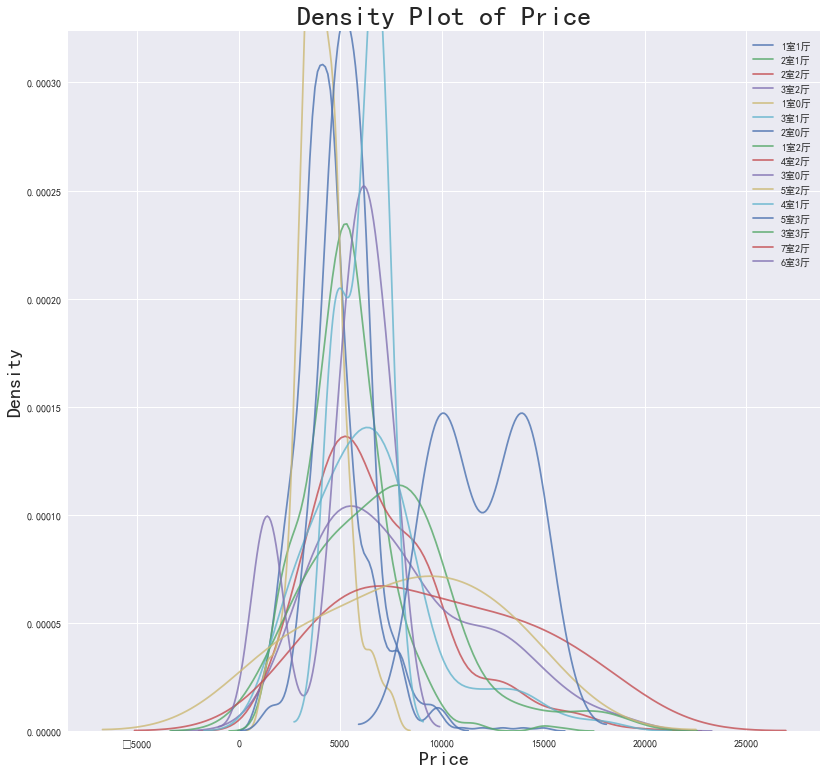

In [79]:
from matplotlib.font_manager import FontProperties
myfont=FontProperties(fname=r'C:\Windows\Fonts\simhei.ttf',size=14)
sns.set(font=myfont.get_name())

plt.figure(figsize=(12,12))
for b_type in types:
    subset = data_set[data_set['Shape']==b_type]
    sns.kdeplot(subset['Price'].dropna(),label = b_type,shade = False,alpha=0.8)
plt.xlabel('Price',size = 20)
plt.ylabel('Density',size=20)
plt.title('Density Plot of Price',size=28)
plt.savefig('image/shape_plot.png')

In [92]:
grouped = data_set['Price'].groupby(data_set['Shape'])
grouped.mean()

Shape
1室0厅     4029.047059
1室1厅     4478.676806
1室2厅     7174.222222
2室0厅     5232.162162
2室1厅     5251.653005
2室2厅     6860.844749
3室0厅     5260.000000
3室1厅     6582.421053
3室2厅     7969.517544
3室3厅    10000.000000
4室1厅     6100.000000
4室2厅     9865.217391
5室2厅     8200.000000
5室3厅    12000.000000
6室3厅     5000.000000
7室2厅    15500.000000
Name: Price, dtype: float64

['1室1厅', '2室1厅', '2室2厅', '3室2厅', '1室0厅', '3室1厅', '2室0厅', '1室2厅', '4室2厅', '3室0厅', '5室2厅', '4室1厅', '5室3厅', '3室3厅', '7室2厅', '6室3厅'] [4029.0470588235294, 4478.67680608365, 7174.222222222223, 5232.1621621621625, 5251.653005464481, 6860.844748858448, 5260.0, 6582.421052631579, 7969.517543859649, 10000.0, 6100.0, 9865.217391304348, 8200.0, 12000.0, 5000.0, 15500.0]


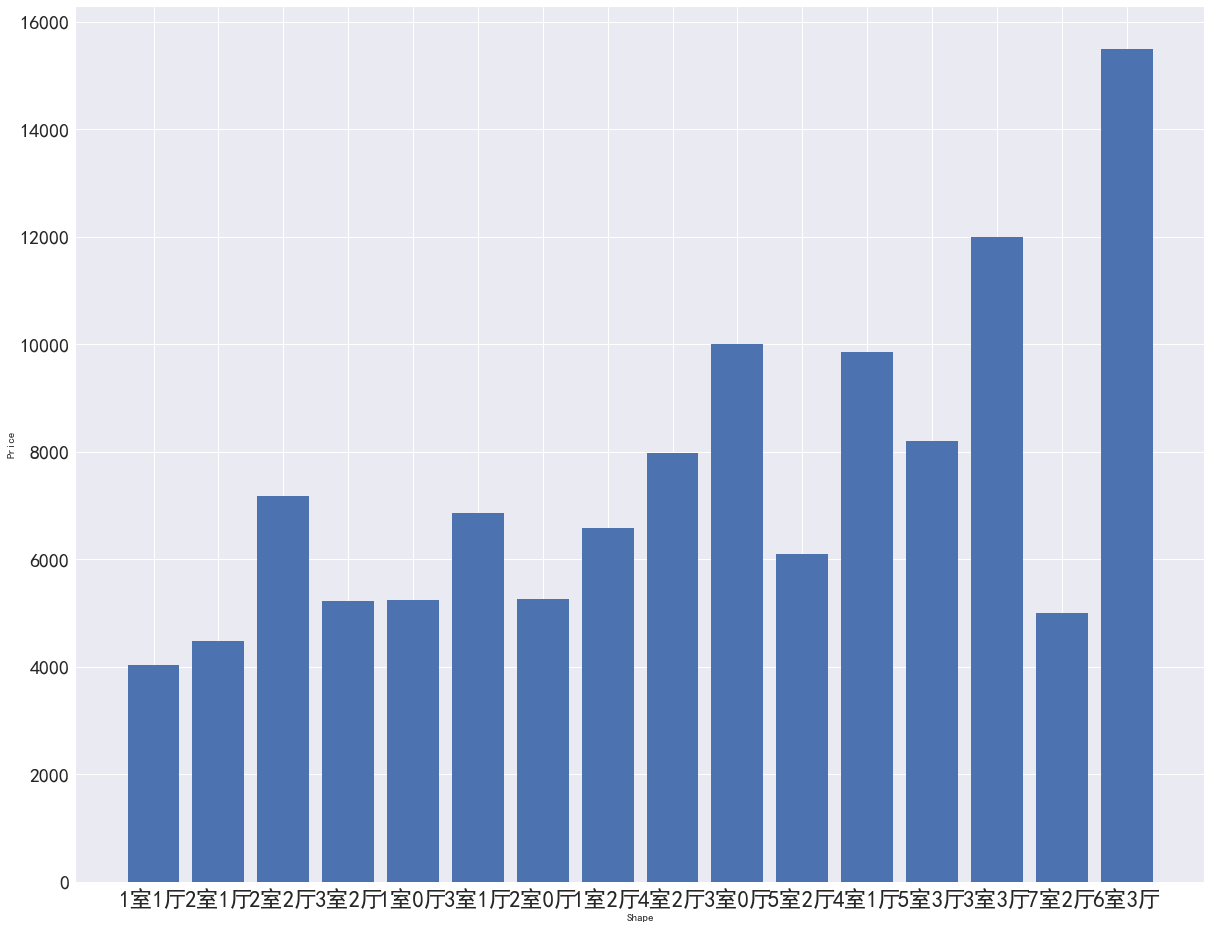

In [101]:
shape_price = data_set['Shape'].value_counts()
shape_price_name = list(shape_price.index)
shape_price_price = [x for x in grouped.mean()]
print(shape_price_name,shape_price_price)
plt.figure(figsize =(18,15))
plt.bar(shape_price_name,shape_price_price)
plt.xticks(fontsize =23)
plt.yticks(fontsize= 20)
plt.xlabel('Shape')
plt.ylabel('Price')
plt.savefig('image/shape_price_bar.png')

## 探究发布日期对房屋特征的影响
* 先看发布日期的范围，是0到365，即最早的时间是一年前
* 根据市辖区分布绘制地图
* 画“"Release_day_before"的多变量关系图，观察变化情况

总结：
发布时间越久的房屋，从大局上看，偏远地区的房屋需要更长时间才能租出去，如金山市的两间房屋，在150天之后才租出去，而位于市中心的房屋也有发布时间较长的，但是这部分的房屋在30-60天就可以租出去。
另一方面，发布时间长的房屋的房屋面积平均在85平米左右，而整体的房屋面积为70平米左右，通过观察[65,75]平米的房间户型发现，大部分房间是2室一厅，标准的好兄弟/好姐妹房间或是情侣房间，对于当下社会的年轻人来说比较适合，所以能够较快的租出去，而对于大于80平米的房间，户型更多是2室2厅和3室2厅，属于家庭房，对于家庭而言，住房是件大事，所以面积大的房屋不容易出租。

此外，发布时间长的房屋，其周围的地铁站数目都比较少，所以比较难租出去。

个人认为还有其他原因影响房屋的出租，如风评，屋内装修、周围环境等

In [219]:
df_release = data[data['Release_day_before']>=180]
df_release.describe()
data[data['Release_day_before']>120]['Release_day_before'].value_counts()

210    16
240    13
365    13
180    11
150    11
270    10
300     5
330     3
Name: Release_day_before, dtype: int64

E:\python\anaconda\lib\site-packages\ipykernel\__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


,Area,Is_lift,Subwayline_Number,Subway_Distance,Is_TV,Is_fridge,Is_washer,Is_air,Is_heater,Is_bed,Is_heating,Is_wifi,Is_closet,Is_gas,Price,Layer_floor,Release_day_before,lng,lat
count,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000
mean,81.787879,0.409091,1.287879,291.303030,0.227273,0.287879,0.257576,0.287879,0.287879,0.318182,0.106061,0.151515,0.287879,0.287879,4879.530303,11.242424,257.727273,121.466606,31.170886
std,39.503268,0.495434,1.443981,353.889247,0.422282,0.456244,0.440650,0.456244,0.456244,0.469340,0.310275,0.361298,0.456244,0.456244,3287.998331,8.344617,64.050352,0.173792,0.120907
min,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1100.000000,3.000000,180.000000,121.041873,30.720051
25%,52.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2500.000000,6.000000,210.000000,121.385631,31.099936
50%,78.500000,0.000000,1.000000,121.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3900.000000,6.000000,240.000000,121.465509,31.185844
75%,98.000000,1.000000,2.000000,486.750000,0.000000,1.000000,0.750000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,5900.000000,15.250000,300.000000,121.537398,31.246430
max,230.000000,1.000000,6.000000,1077.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,16000.000000,40.000000,365.000000,121.872358,31.393564


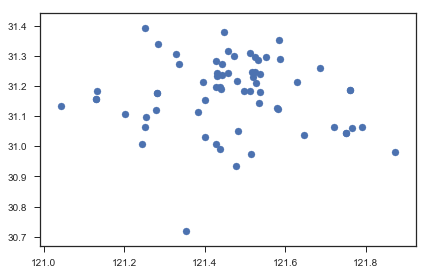

In [220]:
df_lat_lng = df_release[(data['lng']>120.5)&(data['lng']<123)&
                                (data['lat']>30)&(data['lat']<32)]
plt.scatter(df_lat_lng['lng'],df_lat_lng['lat'],data=df_lat_lng)
df_lat_lng.describe()

In [110]:
# 导入到上海地图里面看看这些发布超过1个月的房屋分布
lng = np.array(df_lat_lng['lng'])
lat = np.array(df_lat_lng['lat'])
location = np.vstack([lng,lat]).T
m = folium.Map([35,130],zoom_start=  5)
route = folium.PolyLine(
        location,
        weight = 1,
        color = 'red',
        ).add_to(m)

map_loc = []
k=0
for i in range(len(lng)):
    k = k+1
    map_loc.append([lat[i],lng[i]])
    folium.Marker([lat[i],lng[i]], popup='<i>'+str(k)+'</i>').add_to(m)

map_loc = np.array(map_loc)
# m.save('image/release_day_more30.html')

<class 'pandas.core.frame.DataFrame'>
2479


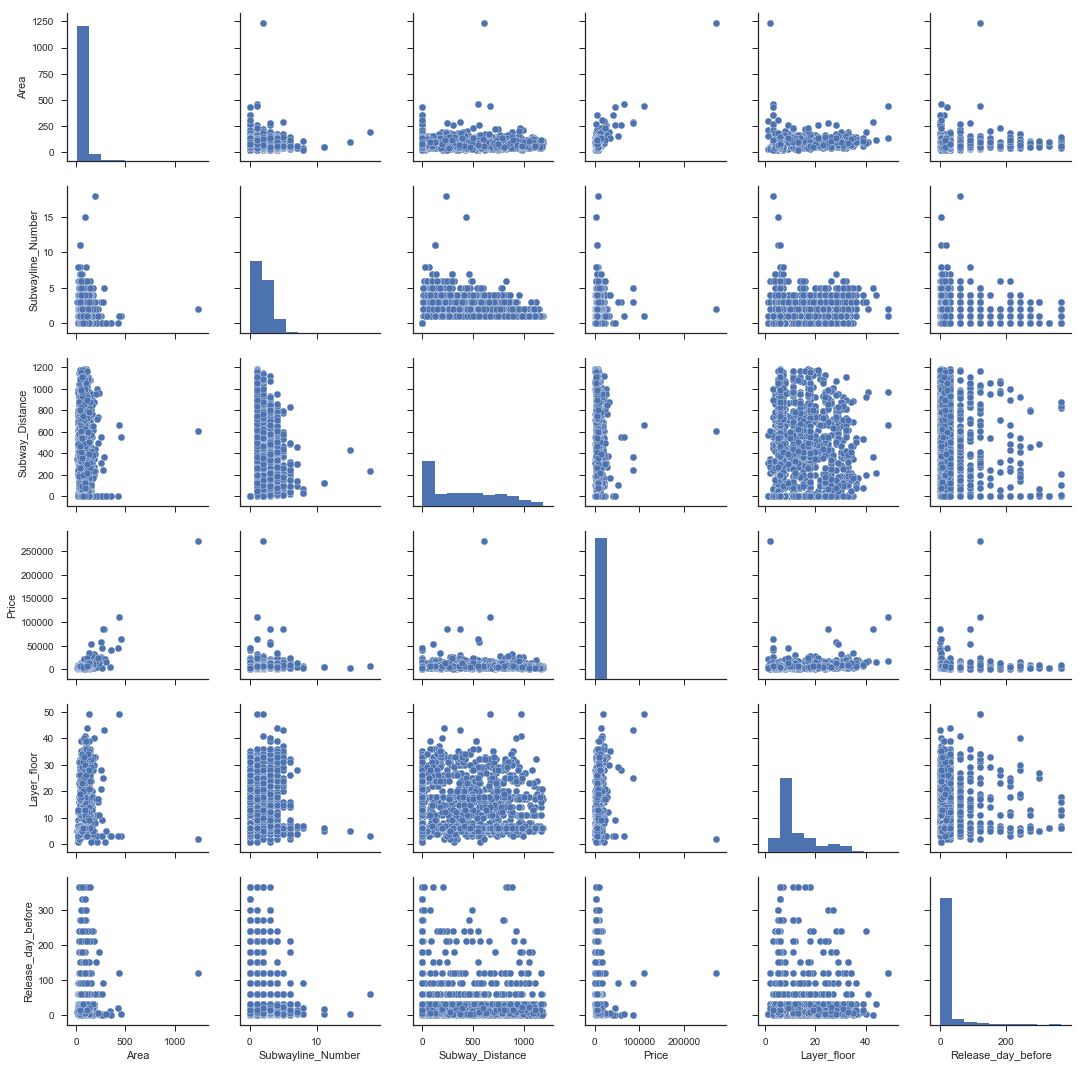

In [193]:
# 看发布日期与房屋面积之间的关系
print(type(df_lat_lng))
df = data[(data['lng']>120.5)&(data['lng']<123)&
                                (data['lat']>30)&(data['lat']<32)]
df = df[['Area','Subwayline_Number','Subway_Distance', 'Price',
                         'Layer_floor','Release_day_before']]
print(len(df))
sns.set(style='ticks',color_codes = True)
sns.pairplot(df)

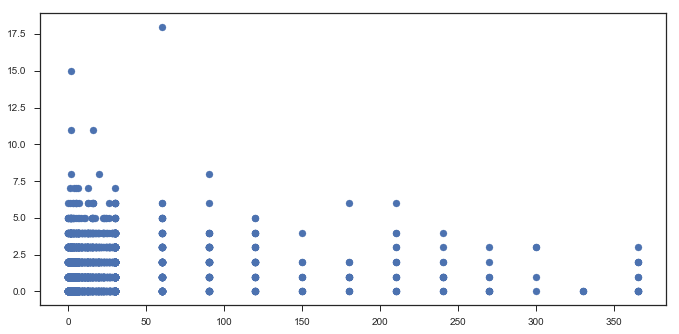

In [206]:
plt.figure(figsize =(10,5))
plt.scatter(list(df['Release_day_before']),list(df['Subwayline_Number']),data=df)

In [213]:
# 住房面积在70平米左右的户型
df_70 = data[(data['Area']>65)&(data['Area']<75)]
df_70['Shape'].value_counts()

2室1厅    162
1室1厅     27
1室2厅     23
2室2厅     17
3室1厅      7
3室0厅      2
2室0厅      2
Name: Shape, dtype: int64

In [215]:
# 住房面积大于80平米左右的户型
df_85 = data[(data['Area']>80)]
df_85['Shape'].value_counts()

2室2厅    376
3室2厅    234
2室1厅     93
3室1厅     71
4室2厅     34
1室2厅     10
5室2厅      9
1室1厅      4
4室1厅      3
5室3厅      2
3室3厅      1
7室2厅      1
6室3厅      1
Name: Shape, dtype: int64

In [216]:
# 对于发布30天以内的房屋，周围的地铁站数目
df_sub = data[data['Release_day_before']<30]
df_sub['Subwayline_Number'].mean()

1.685286783042394

In [218]:
df_level = data[data['Release_day_before']>=365]
df_level['level'].value_counts()

地产小区       9
商务大厦       1
商圈         1
区县         1
UNKNOWN    1
Name: level, dtype: int64

## 周围地铁站数目、距离地铁站的距离与房价之间的关系
* 由于地铁站数目大于6的样本数目较少，不具有代表性，但是从前几个样本的变化可以看出，周围地铁站的数目对房价存在影响
* 距离地铁站的距离对房价并没有太大的影响

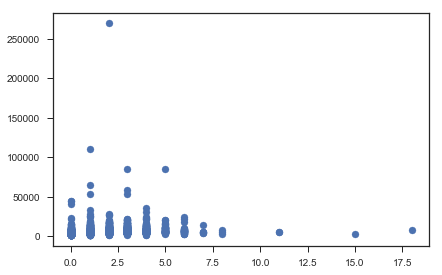

In [222]:
plt.scatter(data['Subwayline_Number'],data['Price'],data=data)

In [225]:
grouped = data['Price'].groupby(data['Subwayline_Number'])
print(data['Subwayline_Number'].value_counts())
grouped.mean()

0     692
1     659
2     588
3     401
4     223
5      58
6      32
7       6
8       3
11      2
15      1
18      1
Name: Subwayline_Number, dtype: int64


Subwayline_Number
0     4463.005780
1     5764.655539
2     6907.448980
3     7210.558603
4     7004.654709
5     9141.379310
6     7351.562500
7     6250.000000
8     5100.000000
11    5150.000000
15    2300.000000
18    7000.000000
Name: Price, dtype: float64

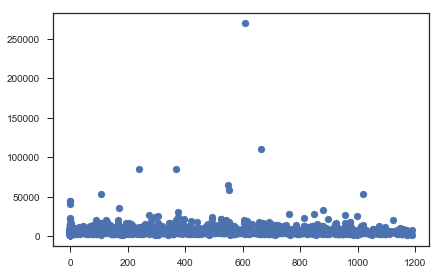

In [228]:
plt.scatter(data['Subway_Distance'],data['Price'],data=data)

In [233]:
data['Subway_Distance']
df_dis = data[data['Subway_Distance']==0]
df_dis_100 = data[(data['Subway_Distance']<500)&(data['Subway_Distance'])>0]
df_dis_200 = data[(data['Subway_Distance']>=500)&(data['Subway_Distance']<1000)]
df_dis_300 = data[(data['Subway_Distance']>=1000)&(data['Subway_Distance']<2000)]
# df_dis_400 = data[(data['Subway_Distance']>=300)&(data['Subway_Distance']<400)]
df_dis_2000 = data[data['Subway_Distance']>=2000]
for i in [df_dis,df_dis_100,df_dis_200,df_dis_300,df_dis_400]:
    print(len(i),i['Price'].mean())

692 4463.005780346821
514 6871.157587548638
894 6697.759507829977
120 5568.333333333333
212 7343.943396226415


## 探究房屋所在小区类型与房价之间的关系

In [234]:
grouped = data['Price'].groupby(data['level'])
grouped.mean()

level
UNKNOWN     5348.101266
乡镇          4725.000000
休闲娱乐        2133.333333
区县          6006.391534
商务大厦        8307.176471
商圈          4571.130435
地产小区        6274.937873
城市          6184.000000
宾馆          9175.000000
工业园区        8994.000000
旅游景点        6133.333333
村庄          4861.538462
火车站         4120.000000
生活服务       11000.000000
购物          5660.000000
道路          5834.848485
餐饮          6557.317073
Name: Price, dtype: float64

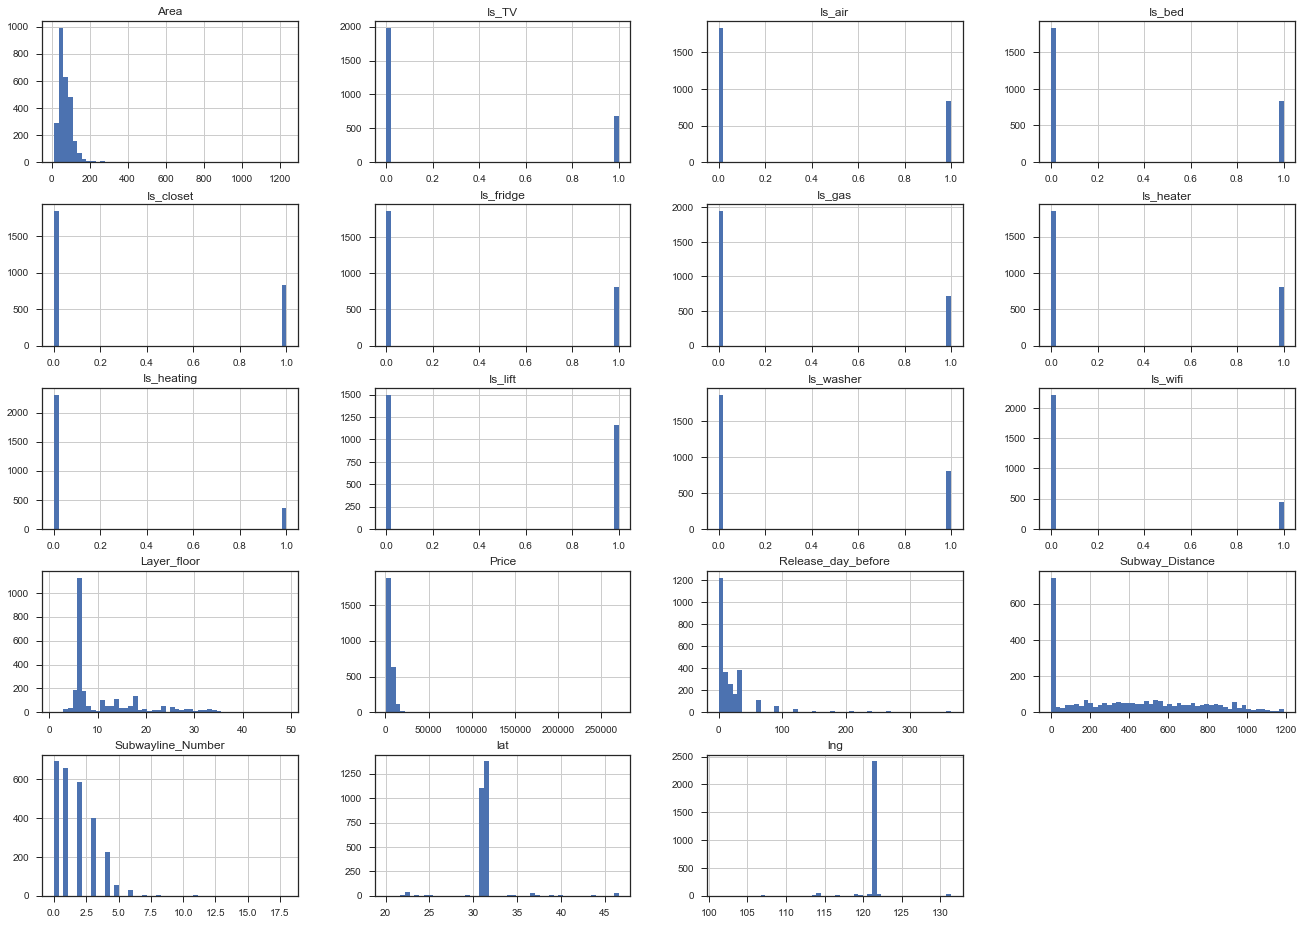

In [246]:
# 直方图
data.hist(bins=50,figsize=(20,15))
plt.show()

In [247]:
# 可以看出数据并不理想

## 探究变量与变量之间的关系
* 是否存在线性关系，常用散点图

In [221]:
# 探究楼层和配备电梯的之间的关系
grouped = data['Layer_floor'].groupby(data['Is_lift'])
print(grouped.mean())

Is_lift
0.0     5.890146
1.0    18.499141
Name: Layer_floor, dtype: float64


绘制变量之间的协相关矩阵图

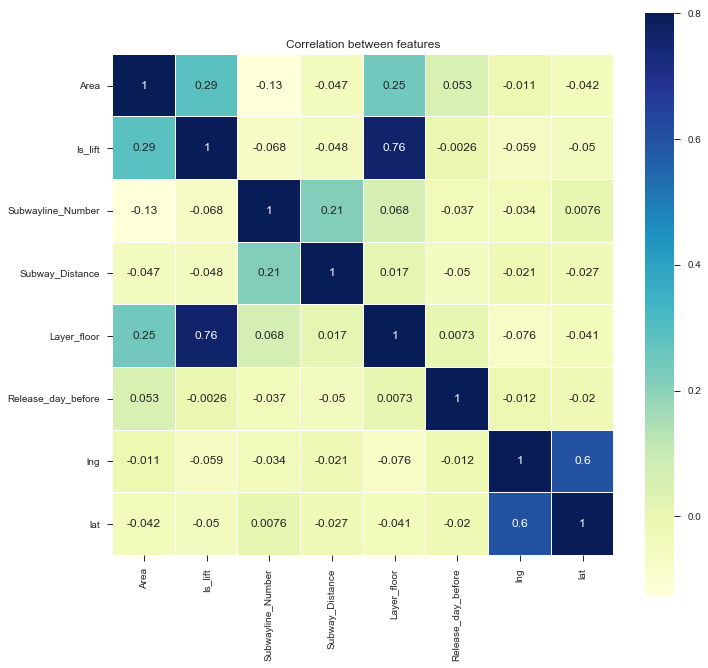

In [235]:

df = data[['Area','Is_lift','Subwayline_Number','Subway_Distance','Layer_floor',
                     'Release_day_before','lng','lat']]
corr=df.corr()
plt.figure(figsize=(10, 10))
sns_plot = sns.heatmap(corr, vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap='YlGnBu',linecolor="white")
plt.title('Correlation between features');
fig = sns_plot.get_figure()
fig.savefig('image/features_heatmap.png')

# 特征工程
* 数据处理
* 特征选择

In [236]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 36 columns):
Address               2666 non-null object
District              2666 non-null object
Community             2666 non-null object
Area                  2666 non-null int64
RentPrice             2666 non-null object
Layer                 2666 non-null object
Shape                 2666 non-null object
Toward                2666 non-null object
Release_Date          2666 non-null object
Rent_Period           2666 non-null object
Is_lift               2666 non-null float64
Is_parking            2666 non-null object
water_way             2666 non-null object
electricity_way       2666 non-null object
Subwayline_Number     2666 non-null int64
Subway_Distance       2666 non-null int64
Is_TV                 2666 non-null int64
Is_fridge             2666 non-null int64
Is_washer             2666 non-null int64
Is_air                2666 non-null int64
Is_heater             2666 non-null int

In [237]:
data.describe()

,Area,Is_lift,Subwayline_Number,Subway_Distance,Is_TV,Is_fridge,Is_washer,Is_air,Is_heater,Is_bed,Is_heating,Is_wifi,Is_closet,Is_gas,Price,Layer_floor,Release_day_before,lng,lat
count,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000
mean,70.973368,0.436609,1.700300,390.617029,0.255064,0.303451,0.300825,0.311328,0.304951,0.311703,0.133908,0.166542,0.309077,0.270818,6091.601650,11.395349,23.786197,121.201037,31.286480
std,43.374157,0.496058,1.544771,347.469262,0.435979,0.459834,0.458703,0.463123,0.460473,0.463276,0.340618,0.372636,0.462200,0.444465,7187.327595,8.223321,46.261838,2.031952,2.358816
min,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1000.000000,1.000000,0.000000,101.280421,20.077154
25%,45.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3800.000000,6.000000,3.000000,121.389156,31.159306
50%,62.000000,0.000000,1.000000,353.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5000.000000,6.000000,10.000000,121.450998,31.218947
75%,89.000000,1.000000,3.000000,668.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,6800.000000,16.000000,29.000000,121.514844,31.276329
max,1236.000000,1.000000,18.000000,1189.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,270000.000000,49.000000,365.000000,131.407375,46.583598


In [339]:
df = data[(data['lng']>120.8)&(data['lng']<123)&
                                (data['lat']>30)&(data['lat']<32)]

In [340]:
lat = np.array(df['lat'])
lng = np.array(df['lng'])
df_heat = [[lat[i],lng[i]] for i in range(len(lat))]
map_osm = folium.Map(location= [35,130],zoom_start = 5)
HeatMap(df_heat).add_to(map_osm)
file_path = r"image/clear_heatmap.html"
map_osm.save(file_path)

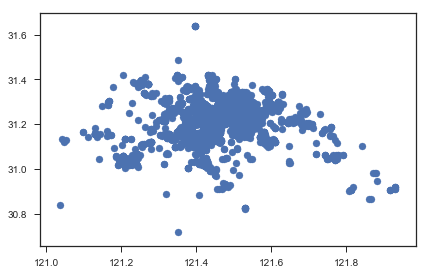

In [341]:
plt.scatter(df['lng'],df['lat'],data=df)

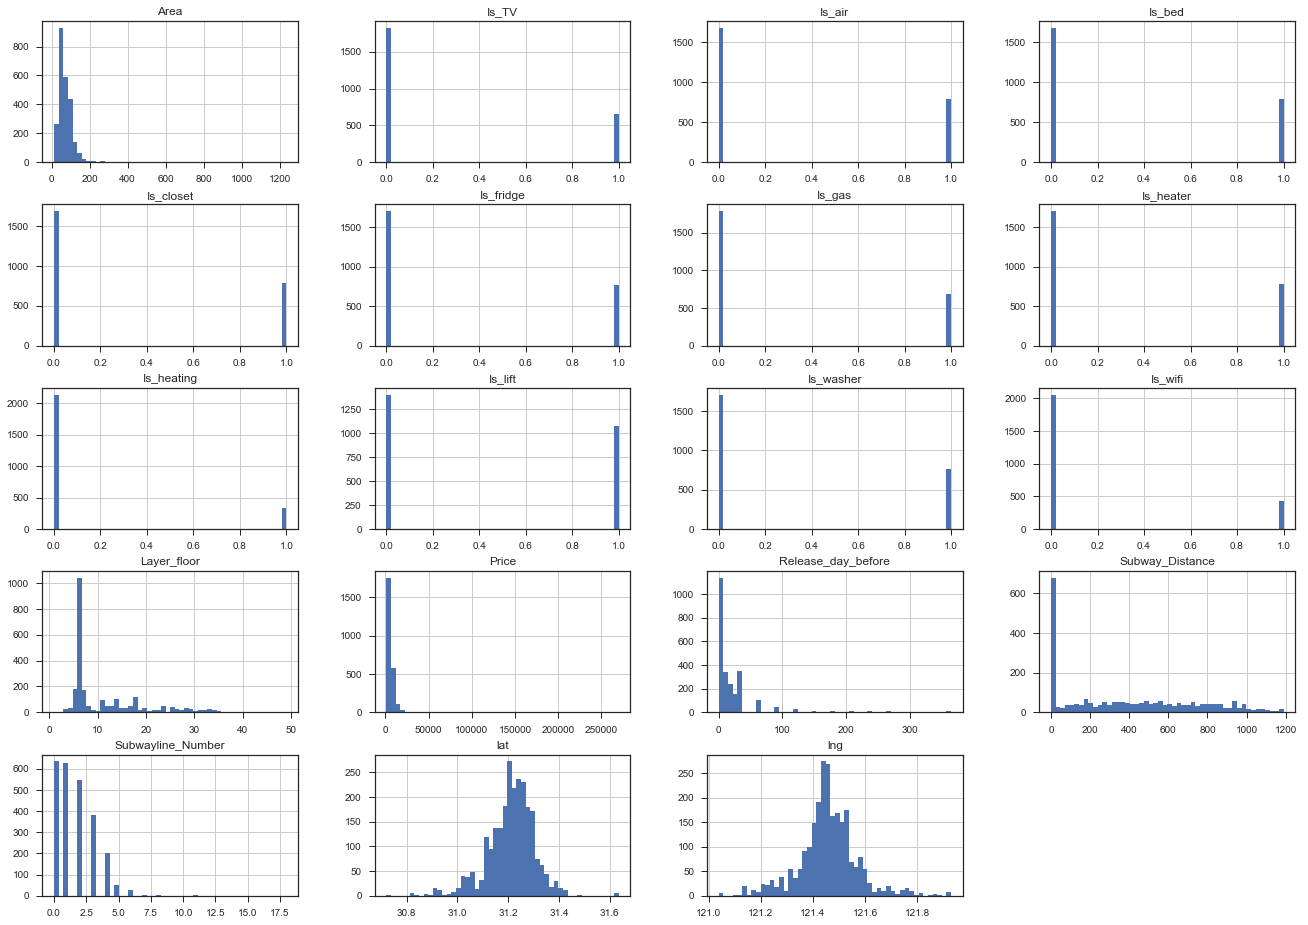

In [342]:
df.hist(bins=50,figsize=(20,15))
plt.show()

通过直方图可以看出，Area特征的数值明显**尾重**，有些模型难以检测，所以需要做一些转换

对于数据中的非数值类型，即Object类型，之前认为户型与面积数呈现正相关，但我认为房间数也会影响出租的价格，因此，构造**房间数**的特征

In [343]:
df.head()
room_list = []
ss = list(df['Shape'])
for s in ss:
    room = s[0]
    room_list.append(int(room))
len(room_list)

2478

In [344]:
df['room'] = room_list
df.head()

E:\python\anaconda\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,Address,District,Community,Area,RentPrice,Layer,Shape,Toward,Release_Date,Rent_Period,...,Catch_time,date,Price,Layer_class,Layer_floor,Release_day_before,lng,lat,level,room
0,闵行,梅陇,梅陇二村,55,3850元/月 (季付价),低楼层/6层,1室1厅,南/北,17天前,1年以内,...,2019-07-13 10:48:00,2019-07-13,3850,低楼层,6,17,121.417683,31.140109,地产小区,1
2,浦东,南码头,光鸿苑,98,8000元/月 (季付价),高楼层/6层,3室2厅,南/北,1个月前,1年以内,...,2019-07-13 10:48:00,2019-07-13,8000,高楼层,6,30,121.522336,31.206077,地产小区,3
3,闵行,春申,高兴花园,48,3500元/月 (季付价),中楼层/6层,1室1厅,南/北,10天前,1年以内,...,2019-07-13 10:48:00,2019-07-13,3500,中楼层,6,10,121.408940,31.117246,地产小区,1
4,徐汇,徐家汇,乐山二村,33,5300元/月 (季付价),中楼层/6层,1室1厅,东南,11天前,1年以内,...,2019-07-13 10:48:00,2019-07-13,5300,中楼层,6,11,121.436942,31.203144,地产小区,1
5,徐汇,徐家汇,南丹小区,30,4850元/月 (季付价),中楼层/6层,1室0厅,南,7个月前,1年以内,...,2019-07-13 10:49:00,2019-07-13,4850,中楼层,6,210,121.436779,31.197589,地产小区,1


## 提取有用的特征
分别是房屋的月租金、经纬度，房屋面积、楼层数、房间数、发布日期、是否有电梯、周围地铁站数目、距离地铁站的距离、房屋设备数

In [345]:
equip_list = []
# # df.info()
# # 此时需要重新编排序号
df.reset_index(drop=True, inplace=True)
df.head()
for i in range(len(df)):
    e_sum = df.loc[i,'Is_TV']+df.loc[i,'Is_fridge']+df.loc[i,'Is_washer']+df.loc[i,'Is_air']+df.loc[i,'Is_heater']+df.loc[i,'Is_bed']+df.loc[i,'Is_heating']+df.loc[i,'Is_wifi']+df.loc[i,'Is_closet']+df.loc[i,'Is_gas']
    equip_list.append(e_sum)
len(equip_list)


2478

In [346]:
df['equip_sum'] = equip_list
df.head()
dfc = df[['Price','lng','lat','Area','Layer_floor','Release_day_before','Is_lift','Subwayline_Number','Subway_Distance','equip_sum','room']]

E:\python\anaconda\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [347]:
# 构造房间平均面积
room_aver_area = []
for i in range(len(dfc)):
    room_area = dfc.loc[i,'Area']/(2*dfc.loc[i,'room'])
    room_aver_area.append(room_area)
len(room_aver_area)

2478

In [348]:
dfc['room_aver'] = room_aver_area

E:\python\anaconda\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [349]:
df_matrix = df.corr()
df_matrix['Price'].sort_values(ascending = False)

Price                 1.000000
Area                  0.753104
room                  0.288605
Layer_floor           0.235532
Is_lift               0.166286
Is_heating            0.157220
Is_wifi               0.145394
Subwayline_Number     0.134384
Is_heater             0.122869
Is_air                0.120163
equip_sum             0.112535
Is_TV                 0.095324
Is_gas                0.093828
Is_washer             0.084591
Is_closet             0.081131
Is_fridge             0.080798
Is_bed                0.073898
lat                   0.067740
Subway_Distance       0.050051
lng                   0.028007
Release_day_before    0.011612
Name: Price, dtype: float64

In [350]:
dfc['log_release'] = dfc['Release_day_before'].apply(lambda x: np.log(x))

E:\python\anaconda\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [351]:
dfc_matrix = dfc.corr()
dfc_matrix['Price'].sort_values(ascending = False)

Price                 1.000000
Area                  0.753104
room_aver             0.506869
room                  0.288605
Layer_floor           0.235532
Is_lift               0.166286
Subwayline_Number     0.134384
equip_sum             0.112535
lat                   0.067740
Subway_Distance       0.050051
lng                   0.028007
Release_day_before    0.011612
log_release          -0.026270
Name: Price, dtype: float64

## 标准化处理

In [352]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
x = np.array(dfc['Area']).reshape(-1,1)
x_std = ss.fit_transform(x)
x_std_list = []
for i in range(len(x_std)):
    x_std_list.append(x_std[i][0])

dfc['Area_std'] = x_std_list

E:\python\anaconda\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
E:\python\anaconda\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
E:\python\anaconda\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [353]:
x_lng = np.array(dfc['lng']).reshape(-1,1)
lng_std = ss.fit_transform(x_lng)
x_lng_list = [x[0] for x in lng_std]
dfc['lng_std'] = x_lng_list

E:\python\anaconda\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [354]:
x_lat= np.array(dfc['lat']).reshape(-1,1)
lat_std = ss.fit_transform(x_std)
x_lat_list = [x[0] for x in lat_std]
dfc['lat_std'] = x_lat_list

E:\python\anaconda\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [355]:
dfd = dfc.copy()
dfd.head()

,Price,lng,lat,Area,Layer_floor,Release_day_before,Is_lift,Subwayline_Number,Subway_Distance,equip_sum,room,room_aver,log_release,Area_std,lng_std,lat_std
0,3850,121.417683,31.140109,55,6,17,0.0,2,764,6,1,27.500000,2.833213,-0.364817,-0.351749,-0.364817
1,8000,121.522336,31.206077,98,6,30,0.0,3,692,6,3,16.333333,3.401197,0.617835,0.572883,0.617835
2,3500,121.408940,31.117246,48,6,10,0.0,0,0,5,1,24.000000,2.302585,-0.524784,-0.428997,-0.524784
3,5300,121.436942,31.203144,33,6,11,0.0,4,665,8,1,16.500000,2.397895,-0.867570,-0.181589,-0.867570
4,4850,121.436779,31.197589,30,6,210,0.0,3,486,6,1,15.000000,5.347108,-0.936127,-0.183028,-0.936127


In [358]:
# 所有的数据都进行标准化处理
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
for i in ['Layer_floor','Release_day_before','Subwayline_Number','Subway_Distance','equip_sum','room_aver','room']:
    x = np.array(dfd[i]).reshape(-1,1)
    x_std = ss.fit_transform(x)
    x_list = [x[0] for x in x_std]
    var = i+'_std'
    dfd[var] = x_list
dfd.head()

E:\python\anaconda\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
E:\python\anaconda\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
E:\python\anaconda\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
E:\python\anaconda\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
E:\python\anaconda\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.

,Price,lng,lat,Area,Layer_floor,Release_day_before,Is_lift,Subwayline_Number,Subway_Distance,equip_sum,...,Area_std,lng_std,lat_std,Layer_floor_std,Release_day_before_std,Subwayline_Number_std,Subway_Distance_std,equip_sum_std,room_aver_std,room_std
0,3850,121.417683,31.140109,55,6,17,0.0,2,764,6,...,-0.364817,-0.351749,-0.364817,-0.647198,-0.144474,0.198776,1.068579,0.806415,1.061297,-1.027148
1,8000,121.522336,31.206077,98,6,30,0.0,3,692,6,...,0.617835,0.572883,0.617835,-0.647198,0.137814,0.850318,0.861537,0.806415,-0.598733,1.609075
2,3500,121.408940,31.117246,48,6,10,0.0,0,0,5,...,-0.524784,-0.428997,-0.524784,-0.647198,-0.296474,-1.104309,-1.128363,0.558856,0.540989,-1.027148
3,5300,121.436942,31.203144,33,6,11,0.0,4,665,8,...,-0.867570,-0.181589,-0.867570,-0.647198,-0.274760,1.501860,0.783897,1.301533,-0.573956,-1.027148
4,4850,121.436779,31.197589,30,6,210,0.0,3,486,6,...,-0.936127,-0.183028,-0.936127,-0.647198,4.046408,0.850318,0.269168,0.806415,-0.796945,-1.027148


In [359]:
dfd_matrix = dfd.corr()
dfd_matrix['Price'].sort_values(ascending = False)

Price                     1.000000
Area_std                  0.753104
lat_std                   0.753104
Area                      0.753104
room_aver                 0.506869
room_aver_std             0.506869
room                      0.288605
room_std                  0.288605
Layer_floor               0.235532
Layer_floor_std           0.235532
Is_lift                   0.166286
Subwayline_Number         0.134384
Subwayline_Number_std     0.134384
equip_sum_std             0.112535
equip_sum                 0.112535
lat                       0.067740
Subway_Distance           0.050051
Subway_Distance_std       0.050051
lng                       0.028007
lng_std                   0.028007
Release_day_before        0.011612
Release_day_before_std    0.011612
log_release              -0.026270
Name: Price, dtype: float64

## 特征选择
将标准化之后的特征筛选出来

In [360]:
df = dfd[['Price','Area_std','lat_std','lng_std','room_aver_std','room_std','Layer_floor_std','Is_lift','Subwayline_Number_std','equip_sum_std','Subway_Distance_std','Release_day_before_std']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2478 entries, 0 to 2477
Data columns (total 12 columns):
Price                     2478 non-null int64
Area_std                  2478 non-null float64
lat_std                   2478 non-null float64
lng_std                   2478 non-null float64
room_aver_std             2478 non-null float64
room_std                  2478 non-null float64
Layer_floor_std           2478 non-null float64
Is_lift                   2478 non-null float64
Subwayline_Number_std     2478 non-null float64
equip_sum_std             2478 non-null float64
Subway_Distance_std       2478 non-null float64
Release_day_before_std    2478 non-null float64
dtypes: float64(11), int64(1)
memory usage: 232.4 KB


In [407]:
df_matrix = df.corr()
df_matrix['Price'].sort_values(ascending = False)

Price                     1.000000
Area_std                  0.753104
lat_std                   0.753104
room_aver_std             0.506869
room_std                  0.288605
Layer_floor_std           0.235532
Is_lift                   0.166286
Subwayline_Number_std     0.134384
equip_sum_std             0.112535
Subway_Distance_std       0.050051
lng_std                   0.028007
Release_day_before_std    0.011612
Name: Price, dtype: float64

## 算法模型
* 构造训练集和测试集
* 建立Baeline模型
* 用线性回归模型进行训练
* 用Lasso回归模型进行训练

In [365]:
from sklearn.model_selection import train_test_split
y = df[['Price']]
X = df.drop(['Price'],axis=1)
x_train,x_test,y_train,y_test=  train_test_split(X,y,test_size = 0.3,random_state=42)

### 建立基线模型

In [405]:
# 返回绝对值误差和均方误差
def mae_and_rmse(y_true,y_pred):
    mae = np.mean(abs(y_true-y_pred))
    rmse = np.sqrt(np.mean((y_true-y_pred)**2))
    return mae,rmse

In [406]:
# 基线模型的效果
baseline_ = np.median(y_train)
mb_mae,mb_rmse = mae_and_rmse(y_test,baseline_)
print("模型的基线是: %0.2f"%baseline_)
print("对于数据集上基线模型的效果：%0.4f"%mb_mae)
print("均方误差:{:.4f}".format(mb_rmse))

模型的基线是: 5000.00
对于数据集上基线模型的效果：2304.2191
均方误差:5493.8311


表明对测试集的平均估计约为2668.86

In [371]:
# 开始训练数据
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

In [373]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1734, 11)
(744, 11)
(1734, 1)
(744, 1)


In [386]:
def fit_and_evaluate(model):
    model.fit(x_train,y_train)
    print(model)
#     print(zip(df.columns,model.coef_))
    print(model.intercept_)
    model_pred = model.predict(x_test)
    model_pred = np.array(model_pred)
    y_test_list = np.array(y_test)
    model_mae = mae(y_test_list,model_pred)
    return model_mae

In [410]:
# 单独进行一次训练，判断该问题是否可用机器学习的方法进行解决
lr = LinearRegression()
lr_mae = fit_and_evaluate(lr)
print(lr_mae)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
[6786.40649144]
(2106.069439975307, 3490.225868381805)


In [389]:
# 第一次线性回归模型得到的训练效果
lr.fit(x_train,y_train)
y_pred = lr.predict(x_test)
for name,weight in zip(x_train.columns,lr.coef_[0]):
    print(name,":",weight)

Area_std : 4352.520672265974
lat_std : 4352.520672265978
lng_std : 102.10605069716664
room_aver_std : -2495.5630137525236
room_std : -4227.549070845195
Layer_floor_std : 1139.4761355303917
Is_lift : -934.8883195672547
Subwayline_Number_std : 992.6947741465309
equip_sum_std : 533.2798314777642
Subway_Distance_std : 261.60663817759604
Release_day_before_std : -156.08051702282958


In [392]:
# 进行多次交叉验证
mae_all = []
lr_weight=[]
for  i in [0,10,42,60,90,30]:
    x_train,x_test,y_train,y_test=  train_test_split(X,y,test_size = 0.3,random_state=i)
    lr.fit(x_train,y_train)
    y_pred = lr.predict(x_test)
    lr_mae = mae(y_test,y_pred)
    mae_all.append(lr_mae)
    lr_weight.append(lr.coef_)
print(mae_all)
print(lr_weight)

[Price    2203.403523
dtype: float64, Price    2212.495709
dtype: float64, Price    2107.906066
dtype: float64, Price    2032.602368
dtype: float64, Price    2133.289778
dtype: float64, Price    2123.454592
dtype: float64]
[array([[ 6264.25315353,  6264.25315353,   211.30823324, -4007.92123149,
        -6804.76369128,   854.05792196,  -915.66979432,   985.968978  ,
          388.57013788,   237.92247566,  -136.08630387]]), array([[ 6377.95133872,  6377.95133872,   103.59171504, -4245.68968396,
        -7145.84870532,  1012.58247403, -1001.9636058 ,   966.20153197,
          422.65401425,   351.37964899,  -137.21134348]]), array([[ 4352.52067227,  4352.52067227,   102.1060507 , -2495.56301375,
        -4227.54907085,  1139.47613553,  -934.88831957,   992.69477415,
          533.27983148,   261.60663818,  -156.08051702]]), array([[ 6205.84178834,  6205.84178834,    87.42667493, -3996.43613552,
        -6934.14756724,  1163.7137009 , -1043.44222568,   962.65285636,
          451.19262936,

In [398]:
# 使用lasso回归
from sklearn.linear_model import Lasso,LassoCV,LassoLarsCV

mae_la = []
la_weight=[]
alpha_list = []
for  i in [0,10,42,60,90,30]:
    la = LassoCV()
    x_train,x_test,y_train,y_test=  train_test_split(X,y,test_size = 0.3,random_state=i)
    la.fit(x_train,y_train)
    y_pred = la.predict(x_test)
    y_pred = np.array(y_pred)
    y_test = np.array(y_test)
    la_mae = mae(y_test,y_pred)
    mae_la.append(la_mae)
    la_weight.append(la.coef_)
    alpha_list.append(la.alpha_)
print(mae_la)
print(la_weight)

E:\python\anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1108: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
E:\python\anaconda\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
E:\python\anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1108: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
E:\python\anaconda\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The defaul

[4285.225049938008, 3516.7010005589887, 4092.524275462657, 3612.25002005045, 3875.11738348327, 3790.022190528149]
[array([ 1.24097937e+04,  1.48542668e-10,  2.07158629e+02, -3.91806409e+03,
       -6.70331354e+03,  8.11365376e+02, -8.55479022e+02,  9.92658527e+02,
        3.86300317e+02,  2.34770686e+02, -1.30970468e+02]), array([ 1.26238109e+04,  6.85244329e-12,  9.82746275e+01, -4.14214295e+03,
       -7.03130007e+03,  9.65269703e+02, -9.37713001e+02,  9.75397230e+02,
        4.20267616e+02,  3.48677266e+02, -1.30757022e+02]), array([ 8.57839779e+03,  8.14176061e-11,  1.00641102e+02, -2.42164334e+03,
       -4.12723161e+03,  1.11994002e+03, -9.04506156e+02,  9.96492415e+02,
        5.32842142e+02,  2.59204546e+02, -1.53157069e+02]), array([ 1.22780043e+04,  4.61462071e-11,  8.32172367e+01, -3.89086978e+03,
       -6.81941045e+03,  1.11598143e+03, -9.80096428e+02,  9.69436155e+02,
        4.48300088e+02,  2.97428297e+02, -1.80542488e+02]), array([ 1.23613085e+04,  3.12309872e-12,  1.0

E:\python\anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1108: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
E:\python\anaconda\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
E:\python\anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1108: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
E:\python\anaconda\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The defaul

In [411]:
# 提取相关性大于0.10的特征，放入线性模型中重新训练
X_new = X[['Area_std','lat_std','room_aver_std','room_std',
 'Layer_floor_std','Is_lift','Subwayline_Number_std','equip_sum_std']]

In [424]:
# 进行多次交叉验证
mae_all = []
rmse_all = []
lr_weight=[]
a= range(100)
for  i in a[::5]:
    x_train,x_test,y_train,y_test=  train_test_split(X_new,y,test_size = 0.3,random_state=i)
    lr.fit(x_train,y_train)
    y_pred = lr.predict(x_test)
    lr_mae,lr_rmse = mae_and_rmse(y_test,y_pred)
    mae_all.append(lr_mae)
    rmse_all.append(lr_rmse)
    lr_weight.append(lr.coef_)
print("绝对值误差的平均值：",np.mean(mae_all),"最小的绝对值误差：",np.min(mae_all))
print(np.mean(rmse_all),np.min(rmse_all))
print("最优情况下的模型系数：",lr_weight[np.argmin(mae_all)])
# print(lr_weight)

绝对值误差的平均值： 2078.192973392283 最小的绝对值误差： 1940.1685597986464
4070.598870203208 2878.0603760824765
最优情况下的模型系数： [[ 3597.95153416  3597.95153416 -1866.07647655 -3271.90549206
   1020.24243039  -751.15284796   981.72732531   577.243386  ]]


In [402]:
u = np.argmin(mae_la)
la_weight_list = la_weight[u][0]
for name,weight in zip(x_train.columns,la_weight[0]):
    print(name,":",weight)

Area_std : 12409.793690474748
lat_std : 1.4854266826425546e-10
lng_std : 207.15862922952152
room_aver_std : -3918.064085449839
room_std : -6703.313543348246
Layer_floor_std : 811.3653761581506
Is_lift : -855.4790216493391
Subwayline_Number_std : 992.6585269204186
equip_sum_std : 386.3003166224728
Subway_Distance_std : 234.7706860998484
Release_day_before_std : -130.97046758060876


In [427]:
u = np.argmin(mae_all)
lr_weight_list = lr_weight[u]
for name,weight in zip(x_train.columns,lr_weight_list[0]):
    print(name,":",weight)

Area_std : 3597.951534164658
lat_std : 3597.95153416466
room_aver_std : -1866.0764765540227
room_std : -3271.9054920616613
Layer_floor_std : 1020.2424303929523
Is_lift : -751.1528479593748
Subwayline_Number_std : 981.7273253071319
equip_sum_std : 577.2433860001842


可以得出结论，对房价影响最大的是房屋的面积，其次是所在的位置、房间的数目、房间的面积(与房屋面积存在相关性)，相比与房屋内的因素，外部因素如交通状况，电梯等因素反而对房价的影响没那么大，推断人们更在意的是住的舒服，有个放松的房间，而不是上班方便的房子。